# Analysis of Low Carbon London smart meter data

This notebook contains some preliminary analysis of smart meter time series data. Whilst of course not an exhaustive exploration of all the exciting things that can be done with this dataset, it gives an idea of my thought process when exploring a dataset like this.

In particular, I limit my investigation to three main areas:

***1. Does the choice of tariff affect electricity usage?***
This will help network operators set up tariffs that can help to balance how energy is used. This can help to reduce the carbon footprint of energy usage by making it easier to incorporate renewables into the network.
   
***2. What are typical patterns of electricity usage?***
Understanding how electricity is used can help with managing the network. It can also help with designing behavioural interventions to encourage consumers to use energy more responsibly.

***3. Can we predict average total electricity usage across all households?***
This is also really useful for managing the network - do we expect load to be higher in the next day/month/year? I use ARIMA/SARIA/SARIMAX models for this.

In [1171]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import datetime as dt

# 1. About this dataset

This is a dataset I have [downloaded from Kaggle](https://www.kaggle.com/datasets/jeanmidev/smart-meters-in-london) but which is also available elsewhere online (e.g. [here](https://innovation.ukpowernetworks.co.uk/projects/low-carbon-london/)).

The dataset was collected as part of the Low Carbon London project led by UK Power Networks. It contains smart meter recordings of electricty consumption by 5,567 London households over the years 2011-2014. Importantly, 1,122 households were given an experimental electricity tariff for the duration of 2013, called a Dynamic Time of Use tariff. This tariff prices electricity based on demand at the time it was used. Usage of these sorts of tariffs is to incentivise a behaviour known as Demand Response, where consumers modify how much electricity they use based on current demand. Demand response can help to balance demand across the energy network, allowing more effective integration of renewable energy sources, and as such forms an important component of the UK's net zero strategy.

Included with this kaggle version of the dataset is weather data scraped from darksky for the period covered by the dataset, and a classification of each household by the [acorn consumber classification system](https://acorn.caci.co.uk/). 

A full description of this dataset can be found [here](http://doc.ukdataservice.ac.uk/doc/7857/mrdoc/pdf/7857_userguide.pdf)

For more information on the Low Carbon London project, including some conclusions, see [here](https://innovation.ukpowernetworks.co.uk/projects/low-carbon-london/)

# 2. Reading in the data
As the dataset is enormous, I'll be doing the exploratory work in this notebook on a subset of the dataset. It is split into blocks, with each household's data being in a single block only. So I'll read in a subset of blocks.

In [2]:
hlfhr = pd.read_csv('archive/halfhourly_dataset/halfhourly_dataset/block_0.csv')
for block in range(15, 112, 15):
    print(f"Loading block {block}")
    hlfhr = pd.concat([hlfhr,pd.read_csv(f'archive/halfhourly_dataset/halfhourly_dataset/block_{block}.csv')])

Loading block 15
Loading block 30
Loading block 45


/var/folders/gd/1fk4c4sx3d7g8y6s4fx0lybh0000gn/T/ipykernel_19073/1993782003.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  hlfhr = pd.concat([hlfhr,pd.read_csv(f'archive/halfhourly_dataset/halfhourly_dataset/block_{block}.csv')])


Loading block 60
Loading block 75
Loading block 90
Loading block 105


In [3]:
hlfhr.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000002,2012-10-12 00:30:00.0000000,0
1,MAC000002,2012-10-12 01:00:00.0000000,0
2,MAC000002,2012-10-12 01:30:00.0000000,0
3,MAC000002,2012-10-12 02:00:00.0000000,0
4,MAC000002,2012-10-12 02:30:00.0000000,0


We need to set the correct datatypes, particularly for the timestep field.

In [4]:
# Set up types
hlfhr['energy(kWh/hh)'] = pd.to_numeric(hlfhr['energy(kWh/hh)'], errors='coerce')  # To float, errors to nan
hlfhr['tstp'] = pd.to_datetime(hlfhr['tstp'])

In [5]:
hlfhr['tstp'].nunique()

39933

Now I also read in details about each household - which tariff they were on, and which ACORN classification they belong to.

In [ ]:
house = pd.read_csv('archive/informations_households.csv')

In [7]:
house.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


## 2.1 Cleaning/filtering dataset

First, let's take a look at how complete the dataset is: do we have a measurement for every household at every timestep?

Text(0.5, 1.0, "There isn't an observation at each timestep for each household")

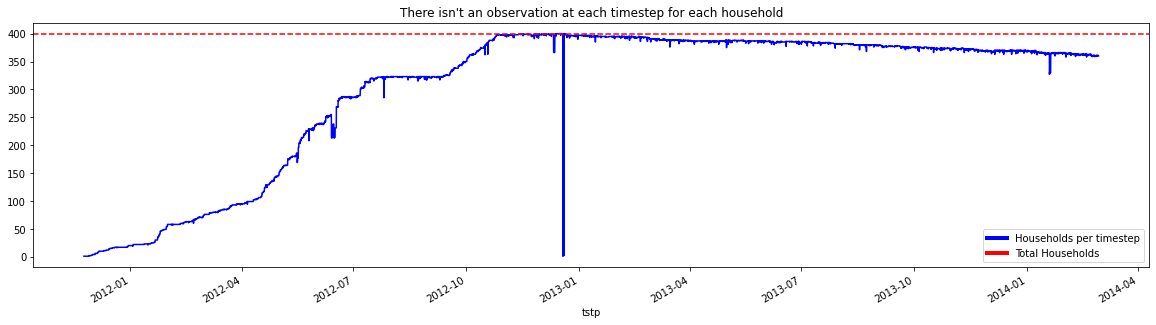

In [8]:
from matplotlib.lines import Line2D
fig, ax1 = plt.subplots(figsize = (20,5))
hlfhr.groupby('tstp')['LCLid'].nunique().plot(color='b')
plt.axhline(y = hlfhr['LCLid'].nunique(), color = 'r', linestyle = '--')
custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4)]
ax1.legend(custom_lines, ['Households per timestep', 'Total Households'])
ax1.set_title("There isn't an observation at each timestep for each household")
plt.show()

_2013 is the year in which the trial was running_, and as a result is the year when the most smart meter data is collected. This is clearly visible on the above graph - the data is most complete for 2013. So for now we'll limit analysis to 2013 only. 

In [9]:
hlfhr = hlfhr[hlfhr['tstp'].dt.year == 2013]

Even so, we probably don't want to deal with households that have too much missing data. Let's check how much data is missing per household and see if we can't drop a few without compromising the quality of our analysis.

In [10]:
hlfhr['tstp'].nunique()

17520

<AxesSubplot:xlabel='tstp'>

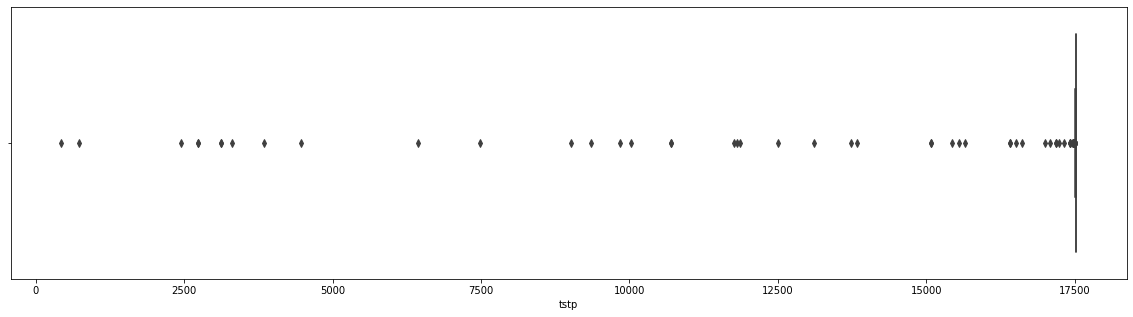

In [11]:
fig, ax1 = plt.subplots(figsize = (20,5))
filled_count = hlfhr.groupby('LCLid')['tstp'].nunique().reset_index()
sns.boxplot(data=filled_count, x='tstp')
plt.show()

Just from eyeballing this distribution, it looks like a good cutoff would be 15,000 data points and above. While we could filter based on on mean and standard deviation, I think eyeballing in this case will be just fine.

In [12]:
low_households = len(filled_count[filled_count['tstp']< 15000])
print(f"Filtering out households with patchy data loses {low_households}/{len(filled_count)} values"
      + f" ({(low_households/len(filled_count)) * 100}%)")

Filtering out households with patchy data loses 25/398 values (6.281407035175879%)


This is acceptable to me, so let's drop these and press on. One interesting further question might be to check whether we are't introducing systematic errors by dropping certain households. For example, if we only drop households that have low energy usage, then we might overestimate energy usage based on the remaining data.

In [13]:
houses_to_keep = filled_count[filled_count['tstp'] >= 15000]['LCLid']
hlfhr = hlfhr[hlfhr['LCLid'].isin(houses_to_keep)]

# 3. Summary statistics on energy usage
First let's look at some summary statistics about how electricity has been used for the these households across 2013. Looking at the distributions below, we can see a very skewed distribution:
***For most 30 minute intervals the electricity usage is relatively low - about 0.2 kWh perh half hour - but we have a large number of outliers where a far greater amount of electricity is being used - up to 8 kWh her half hour.***

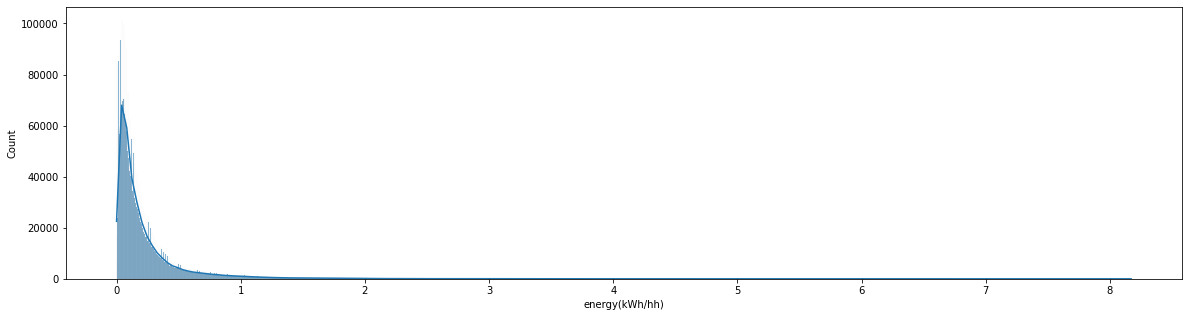

In [698]:
fig, ax1 = plt.subplots(figsize = (20,5))
sns.histplot(hlfhr['energy(kWh/hh)'], kde=True)
plt.show()

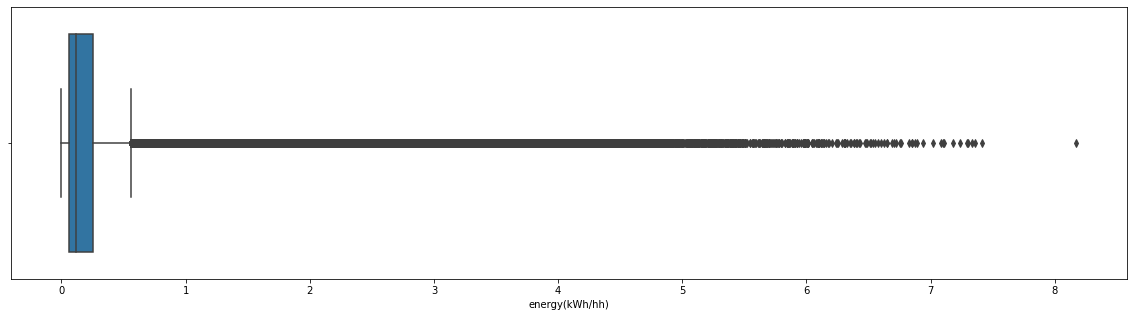

In [699]:
fig, ax1 = plt.subplots(figsize = (20,5))
sns.boxplot(x=hlfhr['energy(kWh/hh)'])
plt.show()

## 3.1 Households on dynamic time of use (ToU) tariffs use less energy on average

Below we can see that the distribution of electricity usage varies depending on whether a household is on a standard tariff or on a dynamic time of use tariff: ***dynamic time of use households (ToU) tend to use less electricity, and in particular have far fewer time periods with very high usage.***

We might be tempted to conclude that there is some causal effect of the tariff on electricity usage, but we should be careful for two reasons: 1) we need to test the statistical significance of this difference and 2) we need to be sure that this difference can only be explained by the tariff.

In [16]:
# Adding in some household information, to see what we can see about different household types
hlfhr = pd.merge(left=hlfhr, right=house[['LCLid', 'stdorToU', 'Acorn', 'Acorn_grouped']], how='left',
               on='LCLid')


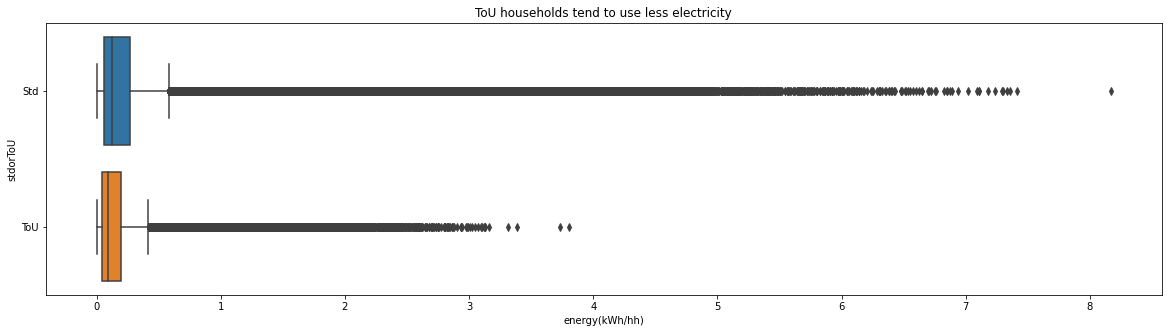

In [700]:
fig, ax1 = plt.subplots(figsize = (20,5))
sns.boxplot(data=hlfhr, x='energy(kWh/hh)', y='stdorToU')
ax1.set_title('ToU households tend to use less electricity')
plt.show()

Inspecting some summary statistics we can see that ToU households not only have a lower mean electricity consumption per half hour, but they also tend to vary less around this mean. ***This implies that demand is not only reduced for ToU tariff households, but is also balanced in that it does not vary so much.*** However, we need to double check that these differences are statistically significant.

In [468]:
print("Checking for equal means:\n"
      +f"Std group mean {hlfhr[hlfhr['stdorToU']=='Std']['energy(kWh/hh)'].mean()}\n"
      +f"ToU group mean {hlfhr[hlfhr['stdorToU']=='ToU']['energy(kWh/hh)'].mean()}")

print("\nChecking for equal variance:\n"
      +f"Std group var {hlfhr[hlfhr['stdorToU']=='Std']['energy(kWh/hh)'].std()**2}\n"
      +f"ToU group var {hlfhr[hlfhr['stdorToU']=='ToU']['energy(kWh/hh)'].std()**2}")


Checking for equal means:
Std group mean 0.23746901098893555
ToU group mean 0.16315389255659365

Checking for equal variance:
Std group var 0.1163182137705236
ToU group var 0.042473994136973135


***Here I have used a 1-sided T test to confirm that the mean Std tariff usage is greater than the mean ToU tariff usage.***

_Note: I have used the equal_var=False option to run Welch’s t-test, because the variance of the two groups is unequal._

In [466]:
# One-sided t-test to check whether Std tariff energy distribution > ToU tariff distribution
stats.ttest_ind(hlfhr[hlfhr['stdorToU']=='Std']['energy(kWh/hh)'],
                hlfhr[hlfhr['stdorToU']=='ToU']['energy(kWh/hh)'],
                equal_var=False, alternative='greater')

Ttest_indResult(statistic=291.38009468246906, pvalue=0.0)

We can see that the p value is < 0.05, so we can reject the null hypothesis that the group means do not differ: we can say that the standard tariff group has a higher mean usage than the ToU tariff group.

## 3.2 Households from certain acorn groups use less electricity on average
So if we've shown a statistically significant difference in mean electricity useage between standard and ToU tariffs, does this show that the tariff is having an effect? 

Not so fast: household electricity consumption is also affected by which Acorn group they fall into. If the ToU and standard tariff groups have different distributions of Acorn groups, this might explain their difference.

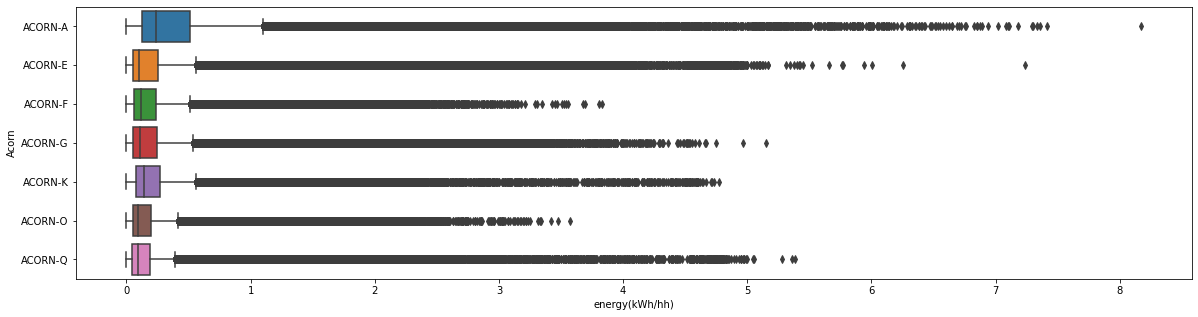

In [495]:
fig, ax1 = plt.subplots(figsize = (20,5))
sns.boxplot(data=hlfhr, x='energy(kWh/hh)', y='Acorn')
plt.show()

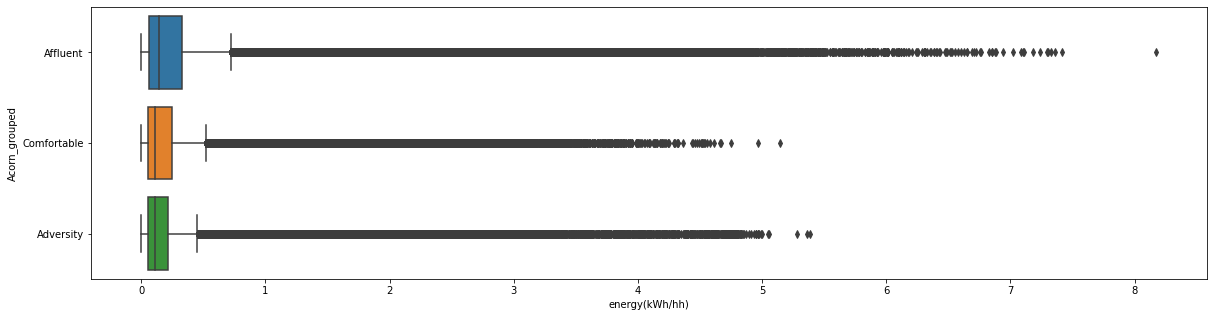

In [496]:
fig, ax1 = plt.subplots(figsize = (20,5))
sns.boxplot(data=hlfhr, x='energy(kWh/hh)', y='Acorn_grouped')
plt.show()

## 3.3 Difference between standard and ToU tariffs could be determined by acorn groups

Here we see a confounding factor is present: the difference between standard and ToU tariff households might be due to the fact that they have different proportions of affluent/confortable/adversity households, which themselves have different usages.

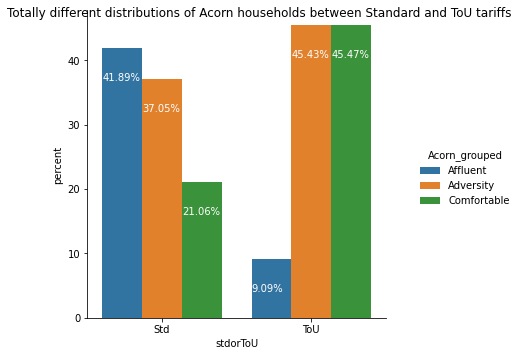

In [39]:
x,y = 'stdorToU', 'Acorn_grouped'

g = (hlfhr
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()-5
    g.ax.text(txt_x,txt_y,txt, color='w')

g.fig.suptitle('Totally different distributions of Acorn households between Standard and ToU tariffs')
plt.show()

This figure shows that affluent households are 41.89% of the standard tariff group, but just 9.09% of the ToU tariff group. This means that the difference in group means could be due to the different household composition of the two tariff groups. 

## 3.4 For all household types, the ToU tariffs use less electricity on average

Here I observe and statistically confirm an important fact: ***within each ACORN group, the ToU households use on average less electricity than standard tariff households. So, we can conlude that there is a different between ToU households and standard tariff households which cannot be entirely explained by ACORN group.***

Is this due to the change in tariff between the two groups? It suggests that this might be the case, but we can't be sure without further exploration - it might be that ToU and standard tariff households have some other systematic difference that we haven't observed and which could explain the difference in their electricity usage.

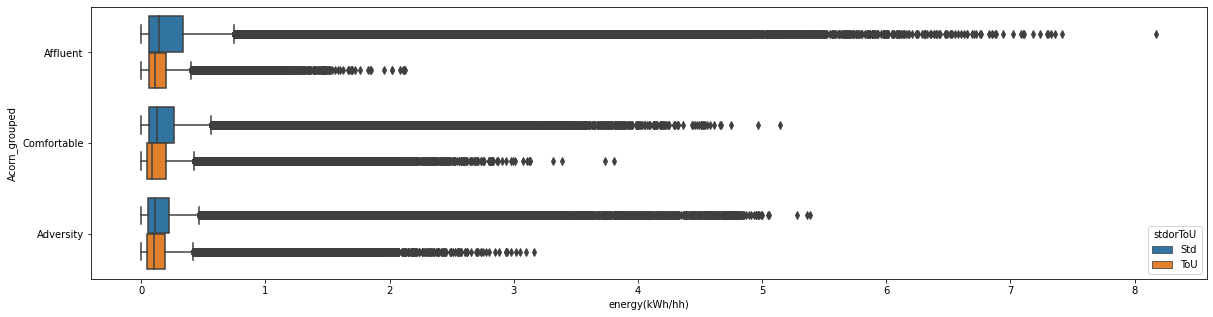

In [497]:
fig, ax1 = plt.subplots(figsize = (20,5))
sns.boxplot(data=hlfhr, x='energy(kWh/hh)', y='Acorn_grouped', hue='stdorToU')
plt.show()

In [489]:
def check_acorn_tariff_means_and_variance(acorn_group):
    
    print("Checking for equal means:\n"
          +f"Std {acorn_group} group mean "
          +f" {hlfhr[(hlfhr['stdorToU']=='Std') & (hlfhr['Acorn_grouped']==acorn_group)]['energy(kWh/hh)'].mean()}\n"
          +f"ToU {acorn_group} group mean " 
          +f"{hlfhr[(hlfhr['stdorToU']=='ToU') & (hlfhr['Acorn_grouped']==acorn_group)]['energy(kWh/hh)'].mean()}")

    print("\n\nChecking for equal variance:\n"
          +f"Std {acorn_group} group variance " 
          +f" {hlfhr[(hlfhr['stdorToU']=='Std') & (hlfhr['Acorn_grouped']==acorn_group)]['energy(kWh/hh)'].std()**2}\n"
          +f"ToU {acorn_group} group variance "
          +f"{hlfhr[(hlfhr['stdorToU']=='ToU') & (hlfhr['Acorn_grouped']==acorn_group)]['energy(kWh/hh)'].std()**2}")
    
    print("\n")

In [490]:
def acorn_t_test(acorn_group):
    print(f"T test for {acorn_group}:")
    # One-sided t-test to check whether Std tariff energy distribution > ToU tariff distribution
    res = stats.ttest_ind(hlfhr[(hlfhr['stdorToU']=='Std') & (hlfhr['Acorn_grouped']==acorn_group)]['energy(kWh/hh)'],
                    hlfhr[(hlfhr['stdorToU']=='ToU') & (hlfhr['Acorn_grouped']==acorn_group)]['energy(kWh/hh)'],
                    equal_var=False, alternative='greater')
    
    print(res)
    

Below, I run tests for each ACORN group to confirm that mean standard tariff electricity usage is higher than mean ToU tariff electricity usage. In all cases the p value < 0.05 which means we can reject the null hypothesis that the means don't differ, and we can instead say that the standard tariff group mean is higher.

In [491]:
check_acorn_tariff_means_and_variance('Affluent')
acorn_t_test('Affluent')


Checking for equal means:
Std Affluent group mean  0.29344069810977813
ToU Affluent group mean 0.15950926506559193


Checking for equal variance:
Std Affluent group variance  0.18028949713375617
ToU Affluent group variance 0.0259435678811877


T test for Affluent:
Ttest_indResult(statistic=219.0868901345844, pvalue=0.0)


In [492]:
check_acorn_tariff_means_and_variance('Comfortable')
acorn_t_test('Comfortable')

Checking for equal means:
Std Comfortable group mean  0.22362898161327352
ToU Comfortable group mean 0.1653487949315553


Checking for equal variance:
Std Comfortable group variance  0.08540374719615121
ToU Comfortable group variance 0.049148752178640925


T test for Comfortable:
Ttest_indResult(statistic=135.41022127273777, pvalue=0.0)


In [493]:
check_acorn_tariff_means_and_variance('Adversity')
acorn_t_test('Adversity')

Checking for equal means:
Std Adversity group mean  0.18204988499556693
ToU Adversity group mean 0.16168661584484031


Checking for equal variance:
Std Adversity group variance  0.05483908356460225
ToU Adversity group variance 0.0390928274221104


T test for Adversity:
Ttest_indResult(statistic=59.788980936368255, pvalue=0.0)


## 3.5 Summary: there's some evidence for an effect of tariff on electricity usage

_Conclusions:_
1. Across all households, average ToU household electricity usage was significantly lower than average electricity usage for standard tariff households.
2. Some of this difference can be explained by the fact that ToU households tend to be less well off households, which in turn tend to use less electricity.
3. However, there is still a difference between ToU and standard electricity usage for the same type of household. This shows there is a tariff effect independent of how affluent households are.

_Possible future explorations:_
1. We could look at the price of electricity at half hourly intervals, and see a more direct/causal effect of pricing on electricity usage for ToU households.
2. We could look at why some households are outliers in terms of electricity usage. There are a number of possible reasons, for example poor EPC ratings or having electric heating rather than gas.

# 4. General trends in electricity usage

Next I'm investigating the general trends in electricity usage - when is usage higher vs. lower? To do this, I construct a new dataset containing the average usage across all households for each half hour period.

To be able to compare across different household types (tariffs, ACORN groups), I also create datasets that construct this average usage per half hour split by tariff and split by ACORN group.

In [706]:
# Construct dataset of average electricity use across all households for each half hour time period
hlfhr_avg = hlfhr.groupby(['tstp'])['energy(kWh/hh)'].mean()
hlfhr_avg = hlfhr_avg.reset_index()
hlfhr_avg.head()

,tstp,energy(kWh/hh)
0,2013-01-01 00:00:00,0.282075
1,2013-01-01 00:30:00,0.253332
2,2013-01-01 01:00:00,0.235155
3,2013-01-01 01:30:00,0.218115
4,2013-01-01 02:00:00,0.198917


In [707]:
# Construct dataset of average electricity use across different tariff households for each half hour time period
hlfhr_avg_tariff = hlfhr.groupby(['tstp', 'stdorToU'])['energy(kWh/hh)'].mean()
hlfhr_avg_tariff  = hlfhr_avg_tariff.reset_index()
hlfhr_avg_tariff.head()

,tstp,stdorToU,energy(kWh/hh)
0,2013-01-01 00:00:00,Std,0.297022
1,2013-01-01 00:00:00,ToU,0.195655
2,2013-01-01 00:30:00,Std,0.264459
3,2013-01-01 00:30:00,ToU,0.189000
4,2013-01-01 01:00:00,Std,0.245635


In [708]:
# Construct dataset of average electricity use across different ACORN households for each half hour time period
hlfhr_avg_acorn = hlfhr.groupby(['tstp', 'Acorn_grouped'])['energy(kWh/hh)'].mean()
hlfhr_avg_acorn  = hlfhr_avg_acorn.reset_index()
hlfhr_avg_acorn.head()

,tstp,Acorn_grouped,energy(kWh/hh)
0,2013-01-01 00:00:00,Adversity,0.193329
1,2013-01-01 00:00:00,Affluent,0.407007
2,2013-01-01 00:00:00,Comfortable,0.232620
3,2013-01-01 00:30:00,Adversity,0.172462
4,2013-01-01 00:30:00,Affluent,0.351145


## 4.1 There's a seasonal trend: electricity usage is higher in autumn/winter and lower in spring/summer

This is not a hugely surprising finding, but good to confirm. It makes sense because winter months have shorter days and are colder, so will involve higher usage of electric lighting/electric heating.

_Note: for clearer plotting I sum the averages across days, so I am plotting the per day total of the average electricity use across all households per half hour_

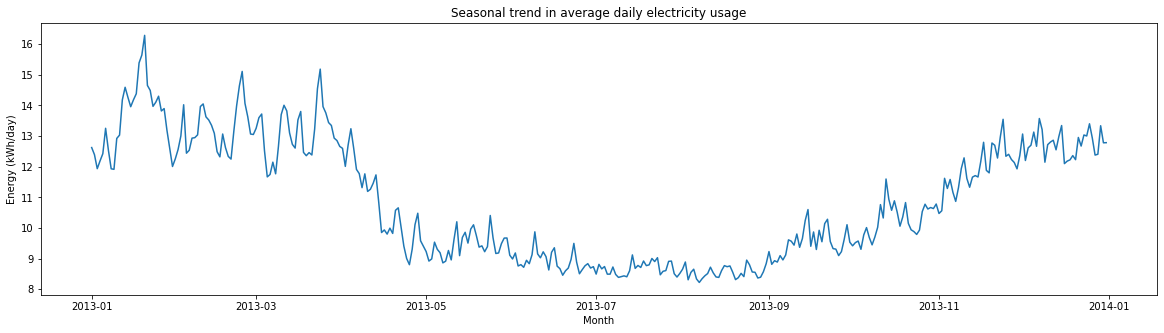

In [717]:
avg_day_totals = hlfhr_avg.set_index('tstp')['energy(kWh/hh)'].resample('d', convention='end').sum().reset_index()
fig, ax1 = plt.subplots(figsize = (20,5))
sns.lineplot(data=avg_day_totals
              , x='tstp', y='energy(kWh/hh)')
ax1.set_title('Seasonal trend in average daily electricity usage')
ax1.set_ylabel('Energy (kWh/day)')
ax1.set_xlabel('Month')
plt.show()

## 4.2 Seasonal trend is repeated for different tariffs, with ToU tariffs consistently lower

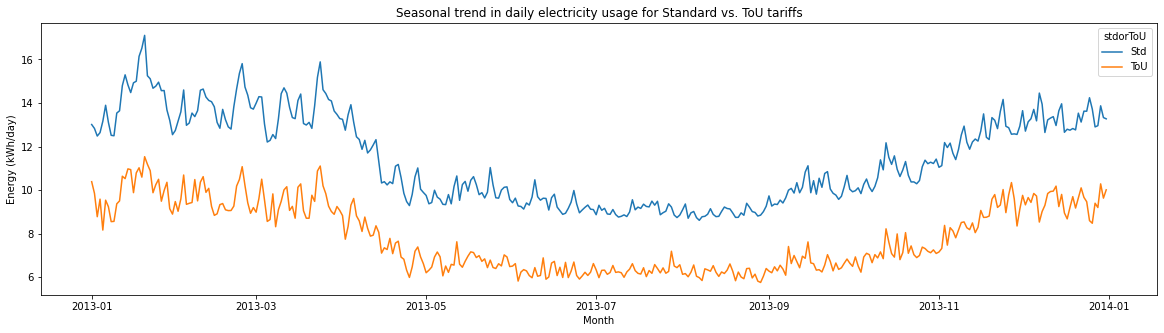

In [716]:
avg_day_totals = hlfhr_avg_tariff.set_index('tstp').groupby(['stdorToU'])['energy(kWh/hh)'].resample('d', convention='end').sum().reset_index()
fig, ax1 = plt.subplots(figsize = (20,5))
sns.lineplot(data=avg_day_totals
              , x='tstp', y='energy(kWh/hh)', hue='stdorToU')
ax1.set_title('Seasonal trend in average daily electricity usage for Standard vs. ToU tariffs')
ax1.set_ylabel('Energy (kWh/day)')
ax1.set_xlabel('Month')
plt.show()

## 4.3 All ACORN groups have a seasonal trend, but affluent households consistently use more electricity

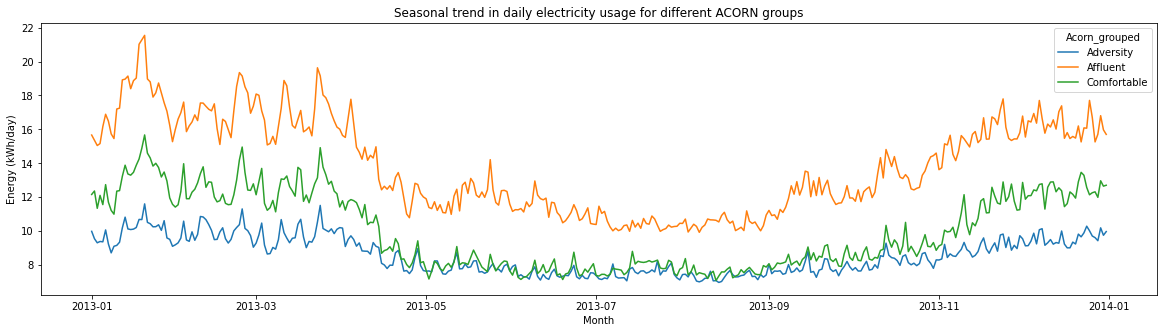

In [719]:
# total daily usage plot
avg_day_totals = hlfhr_avg_acorn.set_index('tstp').groupby(['Acorn_grouped'])['energy(kWh/hh)'].resample('d', convention='end').sum().reset_index()
fig, ax1 = plt.subplots(figsize = (20,5))
sns.lineplot(data=temp
              , x='tstp', y='energy(kWh/hh)', hue='Acorn_grouped')
ax1.set_title('Seasonal trend in average daily electricity usage for different ACORN groups')
ax1.set_ylabel('Energy (kWh/day)')
ax1.set_xlabel('Month')
plt.show()

## 4.4 Grouping by month shows seasonal trends more clearly

This bar plot shows the mean monthly energy usage, across all households, for each month. We can clearly see the seasonal pattern of energy usage found in the previous plots. Interestingly, February shows energy usage that is slightly lower than we might expect give the seasonal trend - this could be worth further investigation.

_Note: Here I am calculating the total energy consumption per household per month._

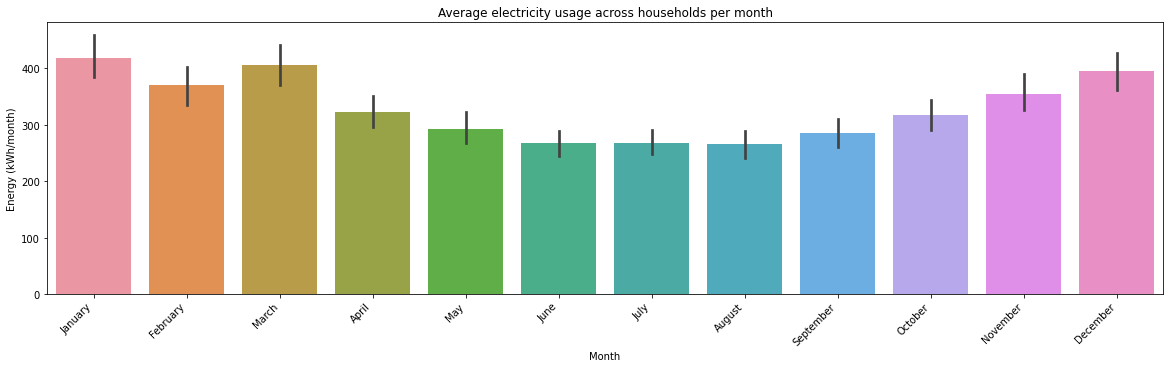

In [724]:
month_totals = hlfhr.set_index('tstp').groupby(['LCLid'])['energy(kWh/hh)'].resample('M', convention='end').sum().reset_index()
fig, ax1 = plt.subplots(figsize = (20,5))
g = sns.barplot(data=month_totals, x=month_totals['tstp'].dt.month_name(), y='energy(kWh/hh)')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
ax1.set_xlabel('Month')
ax1.set_ylabel('Energy (kWh/month)')
ax1.set_title('Average electricity usage across households per month')
plt.show()

## 4.5 Both tariff types show a seasonal trend, with ToU households consistently using less electricity

Interestingly, we can see that confidence intervals (vertical black lines on each bar) are broader in winter months, and particularly so for ToU groups. This implies that energy usage for these months is more variable across households. This could hint at an effect of ToU on electricity usage behaviour in the winter, and is worth further investigation.

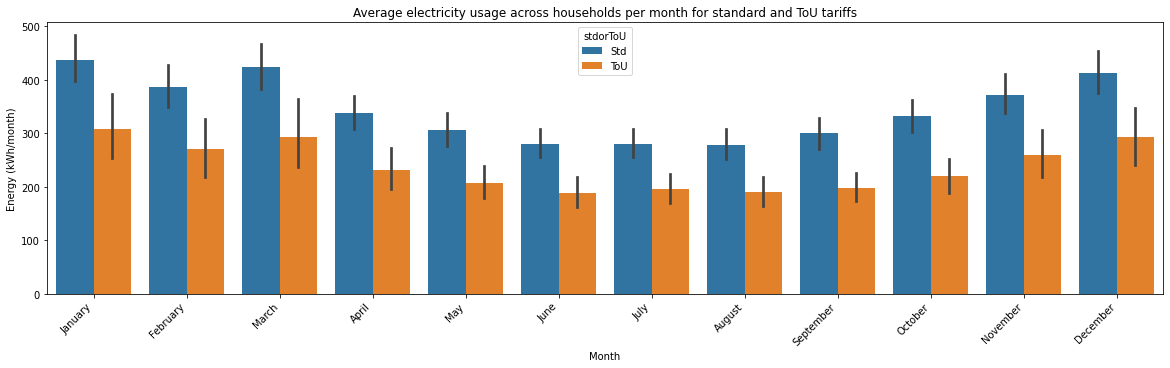

In [728]:
month_totals = hlfhr.set_index('tstp').groupby(
    ['LCLid', 'stdorToU'])['energy(kWh/hh)'].resample('M', convention='end').sum().reset_index()
fig, ax1 = plt.subplots(figsize = (20,5))
g = sns.barplot(data=month_totals, x=month_totals['tstp'].dt.month_name(),
                y='energy(kWh/hh)', hue='stdorToU')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
ax1.set_xlabel('Month')
ax1.set_ylabel('Energy (kWh/month)')
ax1.set_title('Average electricity usage across households per month for standard and ToU tariffs')
plt.show()

## 4.6 All ACORN groups show seasonal variation, with affluent households using more electricity

Again, we see an interesting effect of broader confidence intervals around the means during the winter, specifically for Affluent and Comfortable households. This implies greater variability in energy usage across households, and could be worth further investigation

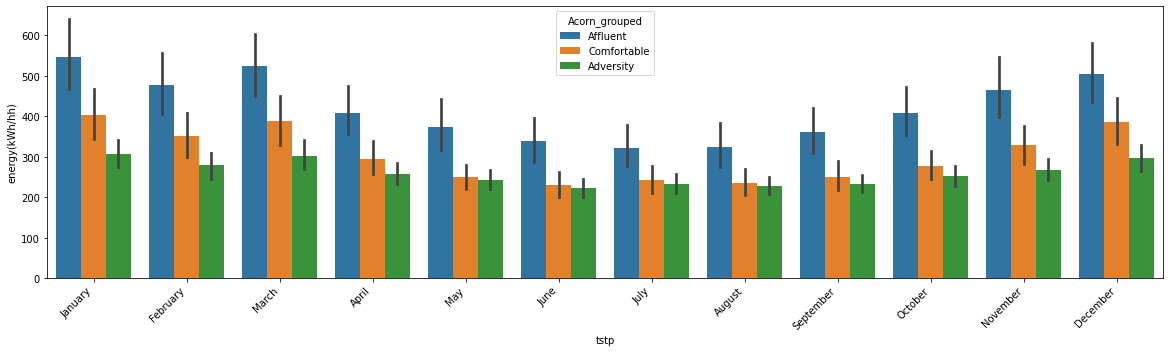

In [729]:
month_totals = hlfhr.set_index('tstp').groupby(
    ['LCLid', 'Acorn_grouped'])['energy(kWh/hh)'].resample('M', convention='end').sum().reset_index()

fig, ax1 = plt.subplots(figsize = (20,5))
g = sns.barplot(data=month_totals, x=month_totals['tstp'].dt.month_name(), y='energy(kWh/hh)',
                hue='Acorn_grouped', hue_order=['Affluent', 'Comfortable', 'Adversity'])
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

## 4.7 Weekends tend to have higher average electricity usage than weekdays, peaking on Sundays
This is another finding that is pretty unsurprising - back in 2013 many households left the house to go to work, so would not be using much electricity. It would be interesting to see how this pattern has changed post 2020....

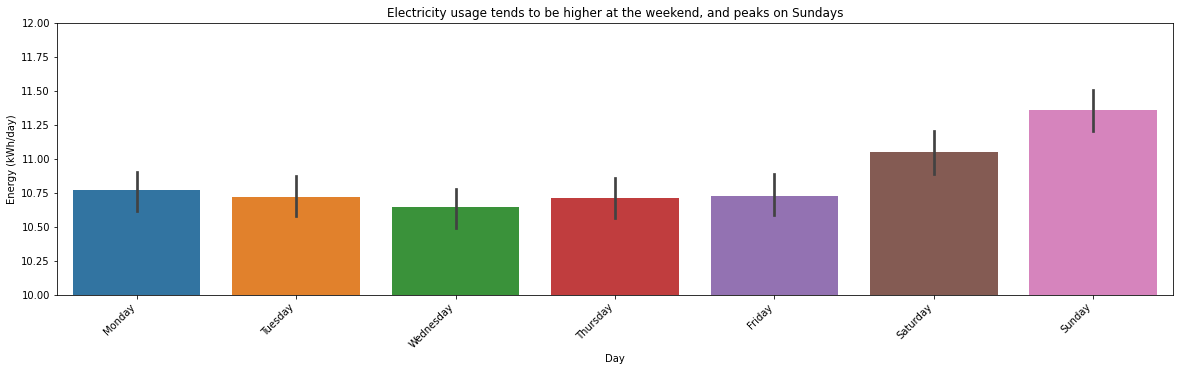

In [733]:
day_totals = hlfhr.set_index('tstp').groupby(['LCLid'])['energy(kWh/hh)'].resample('D', convention='end').sum().reset_index()

day_totals['day'] = day_totals['tstp'].dt.day_name()

fig, ax1 = plt.subplots(figsize = (20,5))
g = sns.barplot(data=day_totals, x='day', y='energy(kWh/hh)',
                order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_ylim([10, 12])
ax1.set_xlabel('Day')
ax1.set_ylabel('Energy (kWh/day)')
ax1.set_title('Electricity usage tends to be higher at the weekend, and peaks on Sundays')
plt.show()

## 4.8 The weekly pattern is present for both tariff types, with ToU households using less energy on average

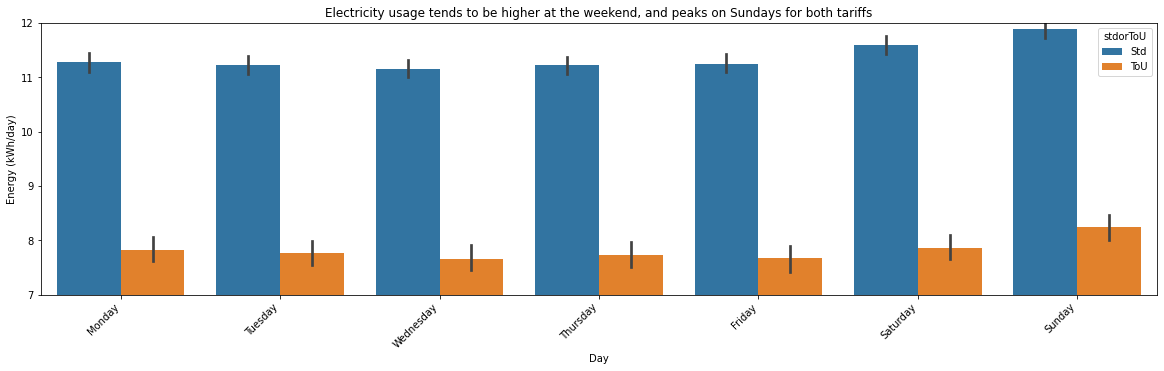

In [744]:
day_totals = hlfhr.set_index('tstp').groupby(['LCLid', 'stdorToU'])['energy(kWh/hh)'].resample('D', convention='end').sum().reset_index()

day_totals['day'] = day_totals['tstp'].dt.day_name()

fig, ax1 = plt.subplots(figsize = (20,5))
g = sns.barplot(data=day_totals, x='day', y='energy(kWh/hh)',
                order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
               hue='stdorToU')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
ax1.set_xlabel('Day')
ax1.set_ylabel('Energy (kWh/day)')
ax1.set_title('Electricity usage tends to be higher at the weekend, and peaks on Sundays for both tariffs')
ax1.set_ylim([7, 12])
plt.show()

## 4.9 The weekly pattern is present for all household types, with affluent households using more energy on average

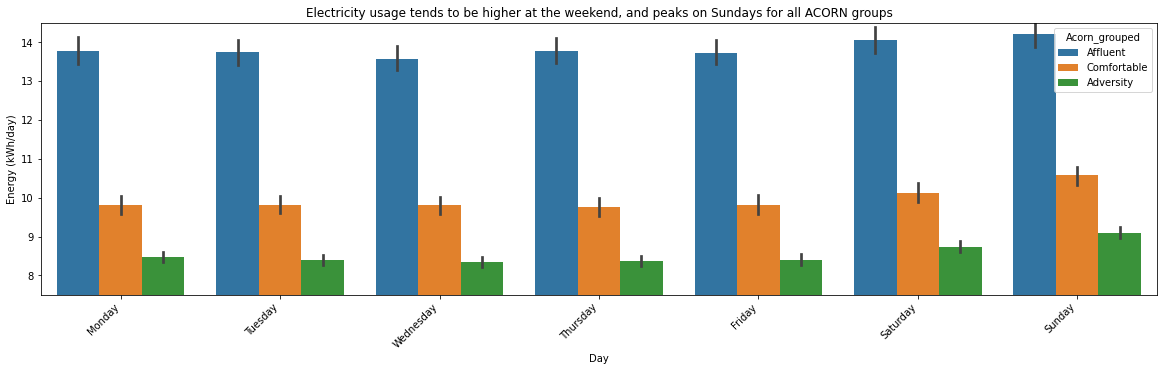

In [745]:
day_totals = hlfhr.set_index('tstp').groupby(['LCLid', 'Acorn_grouped'])['energy(kWh/hh)'].resample('D', convention='end').sum().reset_index()

day_totals['day'] = day_totals['tstp'].dt.day_name()

fig, ax1 = plt.subplots(figsize = (20,5))
g = sns.barplot(data=day_totals, x='day', y='energy(kWh/hh)',
                order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
               hue='Acorn_grouped',
               hue_order=['Affluent', 'Comfortable', 'Adversity'])
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
ax1.set_xlabel('Day')
ax1.set_ylabel('Energy (kWh/day)')
ax1.set_title('Electricity usage tends to be higher at the weekend, and peaks on Sundays for all ACORN groups')
ax1.set_ylim([7.5, 14.5])
plt.show()

## 4.10 Electricity usage drops off at night, picks up to a constant level during the day and peaks in the evening

Another interesting, if unsuprising, finding. This makes intuitive sense - people tend to come home from work and start using electricity for things like doing laundry, making dinner, watching tv etc. This is another case where it would be interesting to see how this trend varies post 2020. It would also be interesting to see whether this trend looks different based on a few different factors: weekends vs. weekdays, bank holidays, school holidays (for households with school age children), and seasonal trends (i.e. winter vs. summmer). 

_Note: For the sake of brevity I have not included plots for different tariffs or ACORN households here. Any differences in this trend will be hard to parse visually and would be better highlighted in another way._

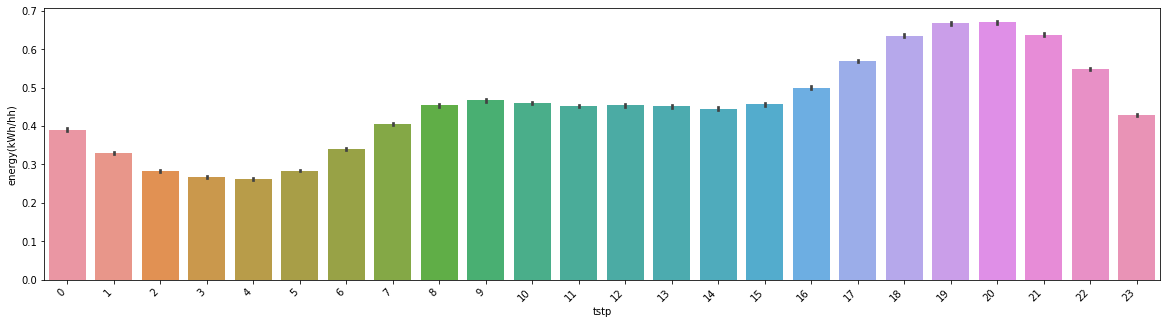

In [747]:
hour_totals = hlfhr.set_index('tstp').groupby(['LCLid','stdorToU'])['energy(kWh/hh)'].resample('H', convention='end').sum().reset_index()
fig, ax1 = plt.subplots(figsize = (20,5))
g = sns.barplot(data=hour_totals, x=hour_totals['tstp'].dt.hour, y='energy(kWh/hh)')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

## 4.11 Summary: there are lots of clear patterns in how electricity is used

_Conclusions:_

1. Electricity usage is higher in the winter months and lower in the summer months
2. Electricity usage is higher at the weekends, peaking on Sundays.
3. Electricity usage is higher during the day, peaking during the evening.

_Possible future questions:_
1. Why does February show lower than expected electricity usage? This might be due to a change in the weather.
2. Would we see a change in electricity usage over the week post 2020 now that people work from home?
3. Could we observe changes in the pattern of electricty usage across the day based on other factors e.g. post 2020, holidays, weekdays vs. weekend?

# 5. Electricity usage has a strong relationship with the weather

To investigate the relationship between weather and electricity usage, I'll resample the half hourly data to be every hour and join it with the provided weather data. 

In [748]:
# Reading in weather data and setting correct types
weather = pd.read_csv('archive/weather_hourly_darksky.csv')
weather['time'] = pd.to_datetime(weather['time'])
weather = weather[weather['time'].dt.year == 2013]

In [41]:
weather.head()

,visibility,windBearing,temperature,time,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
10248,3.70,96,13.56,2013-09-23 23:00:00,12.98,1020.48,13.56,1.36,rain,clear-night,0.96,Clear
10249,2.99,97,12.81,2013-09-24 00:00:00,12.27,1020.08,12.81,0.84,rain,fog,0.97,Foggy
10250,2.16,113,12.19,2013-09-24 01:00:00,11.64,1019.78,12.19,0.44,rain,fog,0.96,Foggy
10251,2.03,84,12.11,2013-09-24 02:00:00,11.54,1019.48,12.11,0.54,rain,fog,0.96,Foggy
10252,1.17,93,12.02,2013-09-24 03:00:00,11.71,1018.73,12.02,0.92,rain,fog,0.98,Foggy


In [42]:
# Resample half hourly dataset to be at the same frequency (hourly) as the weather data
hlfhr['tstp'] = pd.to_datetime(hlfhr['tstp'])
hr = hlfhr.groupby('LCLid').resample('H', on='tstp', convention='end').sum().reset_index()

In [44]:
hr = pd.merge(left=hr, right=weather, how='left', left_on='tstp', right_on='time')

## 5.1 There's no clear link betwen weather and elecricty usage on an hourly basis

Checking correlations of weather variables with energy usage shows correlation coefficients close to 0, meaning no relationship.

In [45]:
hr.corrwith(hr['energy(kWh/hh)']).sort_values()

dewPoint              -0.096036
apparentTemperature   -0.091296
temperature           -0.086103
windBearing           -0.021041
pressure              -0.018976
visibility            -0.009274
humidity              -0.006885
windSpeed              0.037036
energy(kWh/hh)         1.000000
dtype: float64

Perhaps there's a relationship at the daily level. After all, people don't change their behaviour on an hourly basis due to the weather, but they might at the level of a day. There's a daily weather dataset, which we can join with the half hourly data upsampled to the daily level. First we'll read in and clean the daily weather dataset.

In [259]:
daily_weather = pd.read_csv('archive/weather_daily_darksky.csv')
daily_weather['time'] = pd.to_datetime(daily_weather['time'])
daily_weather = daily_weather[daily_weather['time'].dt.year == 2013]
daily_weather['time'] =  pd.to_datetime(daily_weather['time'],format='%Y%m%d').dt.date
daily_weather['time'] = pd.to_datetime(daily_weather['time'])

In [214]:
daily_weather.head()

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
427,21.47,2013-09-24 15:00:00,93,fog,13.61,2013-09-24 05:00:00,0.17,1.18,1016.64,2013-09-24 05:00:00,...,21.47,2013-09-24 05:51:08,2013-09-24 15:00:00,2013-09-24 12:00:00,Foggy in the morning.,2013-09-25 04:00:00,11.53,2013-09-24 15:00:00,2013-09-25 04:00:00,0.67
428,26.19,2013-07-26 16:00:00,221,partly-cloudy-day,12.70,2013-07-26 04:00:00,0.37,1.60,1012.42,2013-07-26 04:00:00,...,26.19,2013-07-26 04:16:40,2013-07-26 16:00:00,2013-07-26 11:00:00,Mostly cloudy until evening.,2013-07-27 05:00:00,15.26,2013-07-26 16:00:00,2013-07-27 05:00:00,0.64
429,25.61,2013-07-09 16:00:00,51,partly-cloudy-day,8.84,2013-07-09 05:00:00,0.13,3.27,1028.39,2013-07-09 05:00:00,...,25.61,2013-07-09 03:55:31,2013-07-09 16:00:00,2013-07-09 11:00:00,Partly cloudy until afternoon.,2013-07-10 04:00:00,12.01,2013-07-09 16:00:00,2013-07-10 04:00:00,0.04
430,23.81,2013-08-08 15:00:00,237,partly-cloudy-day,10.42,2013-08-08 05:00:00,0.30,1.47,1019.26,2013-08-08 05:00:00,...,23.81,2013-08-08 04:36:23,2013-08-08 15:00:00,2013-08-08 13:00:00,Partly cloudy throughout the day.,2013-08-09 06:00:00,11.83,2013-08-08 15:00:00,2013-08-09 06:00:00,0.05
431,5.70,2013-01-11 14:00:00,281,partly-cloudy-day,1.68,2013-01-11 06:00:00,0.52,0.40,1017.62,2013-01-11 06:00:00,...,5.70,2013-01-11 08:03:28,2013-01-11 14:00:00,2013-01-11 11:00:00,Mostly cloudy until evening.,2013-01-11 22:00:00,-1.42,2013-01-11 14:00:00,2013-01-11 23:00:00,0.99


In [311]:
# We have a duplicate day, and we're missing a day - perhaps a day is mislabelled
daily_weather['time'].value_counts()

2013-03-31    2
2013-09-23    1
2013-04-07    1
2013-03-28    1
2013-02-11    1
             ..
2013-08-06    1
2013-05-12    1
2013-10-26    1
2013-05-26    1
2013-12-28    1
Name: time, Length: 364, dtype: int64

In [310]:
# We're missing 27th October 2013
pd.date_range(start = '2013-01-01', end = '2013-12-31' ).difference(daily_weather['time'])

DatetimeIndex(['2013-10-27'], dtype='datetime64[ns]', freq=None)

In [305]:
# Duplicate is not the missing date - looks like an error
daily_weather[daily_weather['time']=='2013-03-31']

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
487,5.88,2013-04-01 15:00:00,68,partly-cloudy-day,-3.45,2013-03-31 23:00:00,0.57,5.5,1011.52,2013-04-01 22:00:00,...,5.88,2013-04-01 05:36:38,2013-04-01 15:00:00,2013-04-01 11:00:00,Mostly cloudy until evening.,2013-04-02 05:00:00,-3.14,2013-04-01 15:00:00,2013-04-02 05:00:00,0.68
683,4.96,2013-03-31 13:00:00,67,partly-cloudy-day,-3.57,2013-03-31 05:00:00,0.40,2.8,1014.56,2013-03-31 21:00:00,...,4.96,2013-03-31 05:38:55,2013-03-31 13:00:00,2013-03-31 12:00:00,Mostly cloudy until morning.,2013-03-31 23:00:00,-2.33,2013-03-31 13:00:00,2013-04-01 02:00:00,0.65


In [312]:
# Dropping the row with a mismatch between time and tempMaxTime/tempMinTime
daily_weather = daily_weather.drop(487)

In [313]:
# Upsampling half hourly dataset to daily dataset
day = hlfhr.groupby('LCLid').resample('D', on='tstp', convention='end').sum().groupby('tstp').mean().reset_index()

In [314]:
# Merging daily energy dataset with daily weather dataset
day = pd.merge(left=day, right=daily_weather, how='left', left_on='tstp', right_on='time')

## 5.2 There is a clear relationship at the daily level: average temperatures (and other weather metrics) correlate with average total energy usage across the day

Here we can see plenty of highly correlated variables. Plotting them below we can see a clear relationship between weather and electricity usage.

Higher electricity usage is associated with lower temperatures, lower dew points, and lower uv index. Thus makes intuitive sense on a causal level, because we can imagine in colder temperatures people tend to use electric heating more, and on cloudier/gloomier days people tend to use electric lighting more.

However, there might also be a non-causal link - we know there's a seasonal effect on how people use electricity and weather is of course correlated with season. It's hard in datasets like this to tease out causation vs. correlation.

In [316]:
day.corrwith(day['energy(kWh/hh)']).sort_values()

apparentTemperatureHigh   -0.902269
apparentTemperatureMax    -0.900217
temperatureHigh           -0.894836
temperatureMax            -0.894097
apparentTemperatureMin    -0.867745
temperatureMin            -0.849328
apparentTemperatureLow    -0.840658
temperatureLow            -0.821569
dewPoint                  -0.788539
uvIndex                   -0.733233
visibility                -0.351512
windBearing               -0.173754
pressure                  -0.148439
moonPhase                 -0.059091
windSpeed                  0.175208
cloudCover                 0.350368
humidity                   0.381091
energy(kWh/hh)             1.000000
dtype: float64

In [264]:
features_names = ['temperatureMax', 'windBearing', 'dewPoint',
       'cloudCover', 'windSpeed', 'pressure', 'apparentTemperatureHigh',
       'visibility', 'humidity', 'apparentTemperatureLow',
       'apparentTemperatureMax', 'temperatureLow', 'temperatureMin',
       'temperatureHigh', 'apparentTemperatureMin', 'moonPhase']

Below we can see plots to demonstrate weather variables relationship (or lack of relationship) with electricity usage.

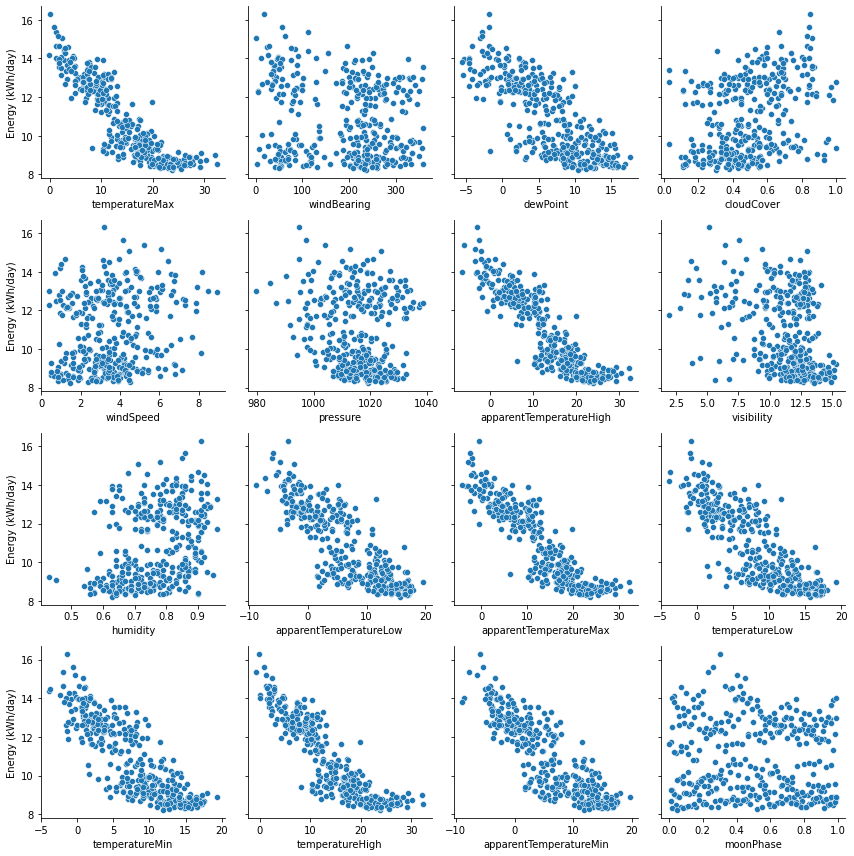

In [751]:
g = sns.FacetGrid(pd.DataFrame(features_names), col=0, col_wrap=4, sharex=False)
for ax, x_var in zip(g.axes, features_names):
    sns.scatterplot(data=day, x=x_var, y='energy(kWh/hh)', ax=ax)
    ax.set_ylabel('Energy (kWh/day)')
g.tight_layout()

plt.show()

This plot shows an example of weather variables over the course of the year relating to energy usage. Here we see when temperature is lower, electricity usage tends to be higher. Whilst some of this can be account for by seasonal variation, there's also a relationship within seasons - this suggests the correlation between temperature and electricity usage isn't just dictated by the time of year.

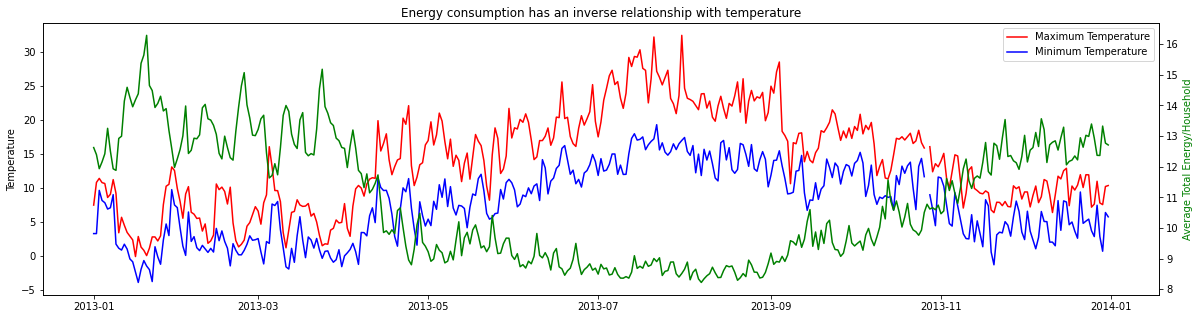

In [754]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(day.tstp, day.temperatureMax, color = 'r', label='Maximum Temperature')
ax1.plot(day.tstp, day.temperatureMin, color = 'b', label='Minimum Temperature')
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(day.tstp,day['energy(kWh/hh)'], color = 'g')
ax2.set_ylabel('Average Total Energy/Household', color = 'g')
plt.title('Energy consumption has an inverse relationship with temperature')
plt.show()

## 5.3 Summary: weather variables are strongly related to electricity consumption at the daily level

_Conclusions:_

1. There's no clear relationship between weather variables and electricity consumption at the hourly level.
2. There is however, a clear relationship between weather and electricity consumption at the daily level - colder, damper, and less sunny days tend to see higher electricity usage.

_Future questions:_
1. What drives the relationship between weather and electricity usage? Is it just that worse weather happens in ther winter when there's shorter daylight hours and people are indoors/at home more?  

# 6. Predicting average energy use per day 

Now that we've seen some exploratory analysis, let's change gear to having a go at some forecasting. 

Here I've decided to forecast the average total daily energy usage across all houses. That is, for each day we get the total energy per household, and then get an average across that. 

## 6.1 Looking for typical time series patterns - seasonality and trends

The first step in forecasting is to understand the data thoroughly. Of course, we've already done a bit of exploratory analysis. Below I do some seasonal decomposition to look at any trends (changes in mean value over time) and seasonality (recurring patterns). 

Statsmodels is a package that has some great convenience functions. Below I use seasonal_decompose(), which estimates the trend, and then finds any seasonality.

In [318]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive', extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

### Seasonal decomposition 
Seasonal decomposition of the data confirms what earlier exploratory analyses told us. There's a seasonal weekly pattern of energy usage (see the third plot below), and we can see a peak approximately 4 times a month - this corresponds to the weekly pattern of energy usage. There is also a trend: usage tends to be higher in the winter months (see second plot below). This is all important information when forecasting, as different models cope better or worse when time series data has a trend or seasonality.

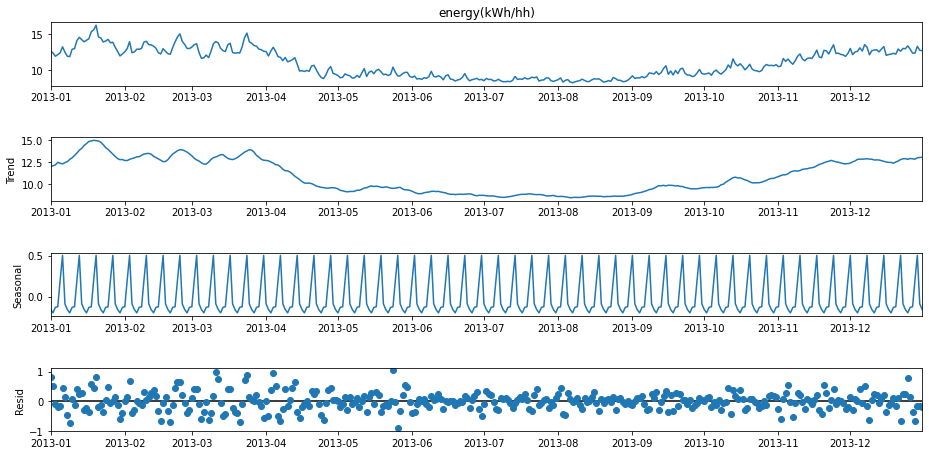

In [319]:
seasonal_decompose(day.set_index('tstp').asfreq('d')['energy(kWh/hh)'])


## 6.2 Checking for stationarity
Data is stationary if statistics such as mean and std don't change much over time. Some time series modelling approaches work best with stationary data, so we need to check if data is stationary and if not transform it to be so in case we want to use any of those models.

In [824]:
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=7).mean() # Choosing 7 as a week seems to be a sensible unit
    rolstd = pd.Series(timeseries).rolling(window=7).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std');
    ax.legend()

Plotting the rolling mean and the rolling sandard deviation gives us a visual intuition as to whether these values are stable over time. Here we can see the they vary quite a bit with time. However, the best way to tell for sure is to use a stastistical test.

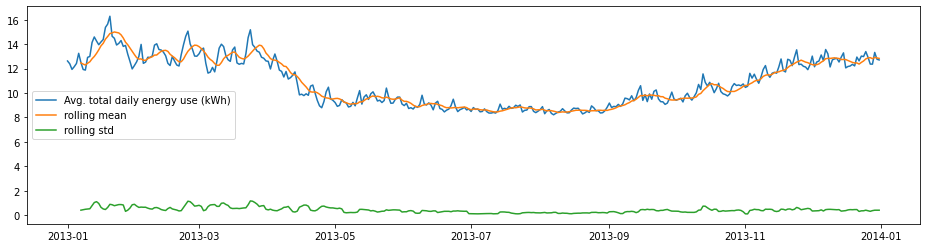

In [825]:
test_stationarity(day.set_index('tstp')['energy(kWh/hh)'],'Avg. total daily energy use (kWh)')

This is the statistical test we can use to check whether a time series is stationary: Augmented Dickey-Fuller. It works similarly to a t-test. With ADF, if we have a high p value fail to reject the null hypothesis that the data is not stationary, and if we have a low p value we reject the null hypothesis in favour of the alternative hypothesis that the data is stationary.

In [819]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [820]:
ADF_test(day.set_index('tstp')['energy(kWh/hh)'],'Avg. total daily energy use (kWh)')

 > Is the Avg. total daily energy use (kWh) stationary ?
Test statistic = -1.505
P-value = 0.531
Critical values :
	1%: -3.4491725955218655 - The data is not stationary with 99% confidence
	5%: -2.8698334971428574 - The data is not stationary with 95% confidence
	10%: -2.5711883591836733 - The data is not stationary with 90% confidence


## 6.3 Forecasting using ARIMA

The first model we'll train is ARIMA (short for Autoregressive Integrated Moving Average). It's a very popular model for forecasting and is used widely e.g. in econometrics.

ARIMA is essentially a linear regression model that uses lagged data as inputs. At a given timestep, then predicted value is the sum of
- A constant
- A linear combination lagged values of Y (up to p timesteps)
- A linear combination of forecasting errors of Y (up to q timesteps in the past)

It is parameterised as ARIMA(p, d, q). I've already explained p and q, and d is the order of differencing that ARIMA uses. For example, zero order differencing (d=0) would be just be the original time series y(t), and first order differencing (d=1) would be y(t) - y(t-1). 

***How do we set these p, d, and q?***

_Choosing d_

Received wisdom is that the best value of d is the smallest value that allows the time series to pass the ADF test. If a time series is already stationary, then d=0. 

The autocorrelation of a time series with itself can help confirm that a value of d is appropriate. If an autocorrelation is positive for many lags, then further differencing is required. If autocorrelation quickly becomes negative (e.g. in the first few lags), then the series has been over-differenced (a bad thing that makes models worse) and less differencing is required. 


_Choosing p and q_

One option once we have set d is to do a grid search for p and q. We train ARIMA models with varying values of p and q and choose the parameter combination that has the best score of the [Akaike’s Information Criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) metric. AIC essentially measures how badly a statistical model fits the data - we just choose the (p, d, q) combination that has the lowest AIC score.

Another way to get p and q is to examine the autocorrelation and the partial autocorrelation of the differenced series. I will explain here, but also demonstrate this graphically.

As a rule of thumb, we can set q to the number of autocorrelation lags which have values above significance.

For p, we can examine the partial autocorrelation, which is the autocorrelation of a time series with it's own lags but controlling for contributions of any intermediate lags. As a rule of thumb, we can set p to be equal to the number of lag terms that are above significance in the partial autocorrelation.

As might be clear, choosing these parameters is a little bit of an art. A good overall rule is to have the smallest values for each parameters to get good results, as this gives the simplest model. So if there's ever any doubt about a parameter choice you can err on the side of caution and select the smaller.

### 6.3.1 Setting the d parameter
The ADF test we previously did shows a P-value > 0.05, so we can infer that the data is not stationary. It seems that d=0 is therefore not appropriate. However, if we take the first difference, we can see the we pass the ADF test. This means that d=1 is a good parameter choice.


 > Is the first differenced data stationary ?
Test statistic = -5.578
P-value = 0.000
Critical values :
	1%: -3.4491725955218655 - The data is  stationary with 99% confidence
	5%: -2.8698334971428574 - The data is  stationary with 95% confidence
	10%: -2.5711883591836733 - The data is  stationary with 90% confidence


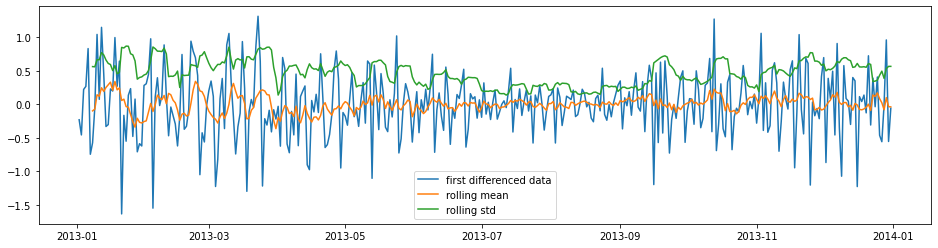

In [879]:
y = day.set_index('tstp')['energy(kWh/hh)']

# Checking the first difference
test_stationarity(y.diff(), 'first differenced data')
ADF_test(y.diff(), 'first differenced data')

Because the ADF test is significant at 1-differenced data, we can conclude that the ADF d parameter should be 1. 

### 6.3.2 Finding optimal p and q parameters using grid search
We can use grid search to find the optimal ARIMA parameters p and q.

In [872]:
import itertools 
from statsmodels.tsa.arima.model import ARIMA

def arima_grid_search(y, d):
    p = q = range(0, 3)
    pdq = list(itertools.product(p, [d], q))
    
    mini = float('+inf')
    
    
    for param in pdq:
        try:
            mod = ARIMA(y_7lag_detrend,order=(1,0,0))
            results = mod.fit()

            if results.aic < mini:
                mini = results.aic
                param_mini = param
                param_seasonal_mini = param_seasonal

        except:
            continue
    print('The set of parameters with the minimum AIC is: ARIMA{} - AIC:{}'.format(param_mini, mini))

In [1072]:
arima_grid_search(y, 1)

The set of parameters with the minimum AIC is: ARIMA(0, 1, 0) - AIC:1048.514995696336


### 6.3.3 Confirming p and q parameters by checking autocorrelation and partial autocorrelation

Grid search found that the parameter set with minimum AIC is p=0, q=0.

We can check the autocorrelation and the partial autocorrelation to make sure that these empirically-selected parameters make theoretical sense.

From the autocorrelation below we see a peak in the lag at 0 but then no significant peaks until much later in the plot. This confirms that q=0 is a good parameter choice.

From the partial autocorrelation we also see that there's not really a significant peak after 0 until later in the plot. This confirms that p=0 is a good parameter choice.


In both plots, we see peaks at a lag of 7 and a lag of 14. This is because we have a seasonal trend in the dataset - we have a repeating weekly pattern of electricity usage. ARIMA models aren't that great at dealing with seasonality. So after we've trained out ARIMA model, we'll go onto look at an improved model, the SARIMA (Seasonal ARIMA) model.

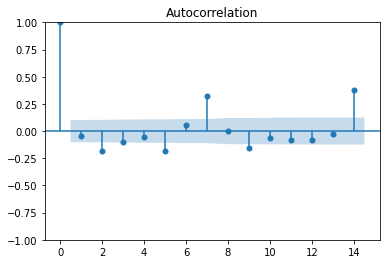

In [870]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(y.diff().dropna(), lags=14)
plt.show()

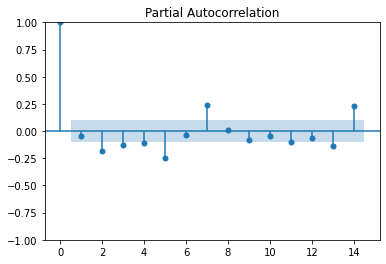

In [871]:
plot_pacf(y.diff().dropna(), lags=14, method='ywm')
plt.show()

### 6.3.4 Training our ARIMA model

In [1108]:
arima_model = ARIMA(y,order=(0, 1, 0))
arima_res = arima_model.fit()

# Print mean absolute error
print('MAE: %.3f' % arima_res.mae)

MAE: 0.399


/Users/hector/anaconda3/envs/kaggle/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/hector/anaconda3/envs/kaggle/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/hector/anaconda3/envs/kaggle/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [1109]:
print(arima_res.summary())

                               SARIMAX Results                                
Dep. Variable:         energy(kWh/hh)   No. Observations:                  365
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -247.823
Date:                Wed, 22 Feb 2023   AIC                            497.645
Time:                        13:25:30   BIC                            501.543
Sample:                    01-01-2013   HQIC                           499.194
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2285      0.015     15.393      0.000       0.199       0.258
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):                 8.02
Prob(Q):                              0.41   Pr

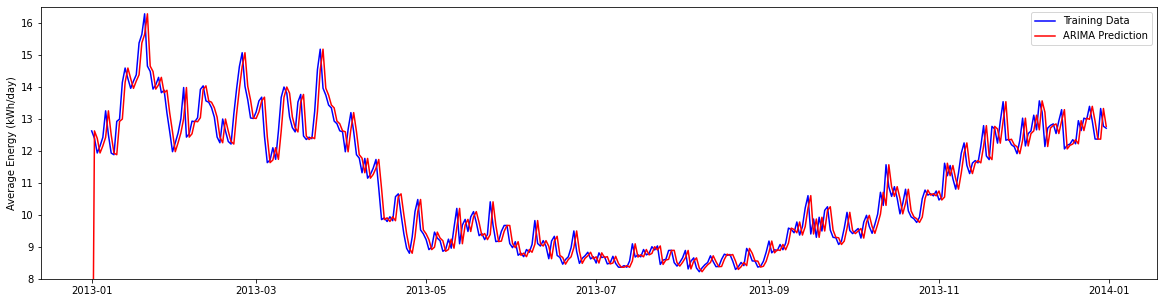

In [1110]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(y, color = 'b', label='Training Data')
ax1.plot(arima_res.fittedvalues, color = 'r', label='ARIMA Prediction')
ax1.set_ylabel('Average Energy (kWh/day)')
ax1.legend()
ax1.set_ylim([8, 16.5])
plt.show()

In the plot above, it looks like the ARIMA model does a good job of predicting average energy for the training data. However, the parameter choice of (0, 1, 0) means that the model is essentially just predicting the next timestep's energy usage as the current timestep's energy usage. We can confirm this by shifting the arima fitted values and comparing them to the training data values. This plot below shows that they are perfectly aligned

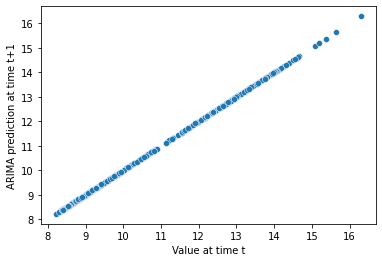

In [1111]:
g = sns.scatterplot(x=y[:-1].values, y=arima_res.fittedvalues[1:].values)
g.set_xlabel('Value at time t')
g.set_ylabel('ARIMA prediction at time t+1')
plt.show()

### 6.3.5 Forecasting using the ARIMA model
To test the ARIMA model, we'll create a test dataset from January 2014 data. We're going to see how well our models do at predicting all of January 2014. So the model has been trained on all fo 2013, then we'll output predictions for all of 2014 without seeing any of the 2014 data. This is equivalent to an energy company asking the question "what will average energy usage look like in the next month?" on new year's eve 2013. 

In [ ]:
# Creating a testing dataset from 2014 data
test = pd.read_csv('archive/halfhourly_dataset/halfhourly_dataset/block_0.csv')
for block in range(15, 112, 15):
    print(f"Loading block {block}")
    test = pd.concat([test,pd.read_csv(f'archive/halfhourly_dataset/halfhourly_dataset/block_{block}.csv')])
    
# Set up types
test['energy(kWh/hh)'] = pd.to_numeric(test['energy(kWh/hh)'], errors='coerce')  # To float, errors to nan
test['tstp'] = pd.to_datetime(test['tstp'])

# Limiting data to january 2014
test = test[(test['tstp'].dt.year== 2014) & (test['tstp'].dt.month == 1)]

# Upsampling half hourly test dataset to daily dataset
test = test.groupby('LCLid').resample('D', on='tstp', convention='end').sum().groupby('tstp').mean().reset_index()
test = test.set_index('tstp')['energy(kWh/hh)']

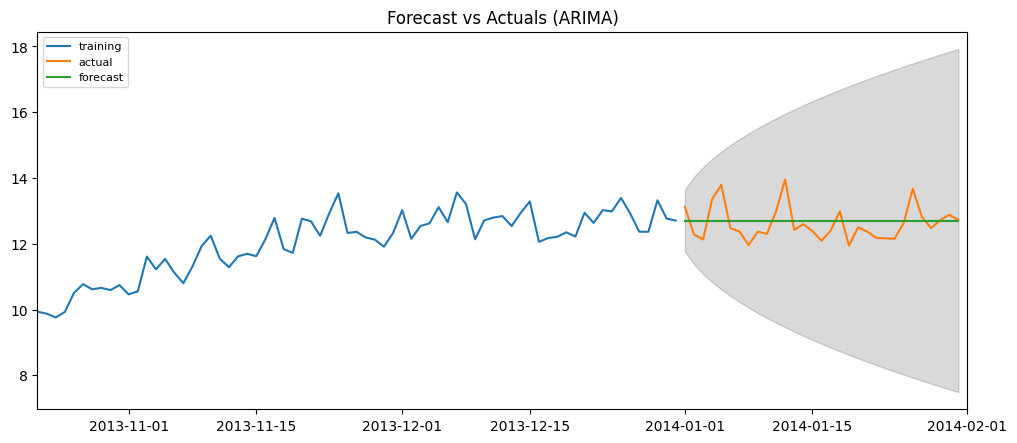

In [1141]:
# Forecast the future using ARIMA
arima_forecast = arima_res.get_forecast(len(test), alpha=0.05) # 95% conf

# Forecasts as pandas series
cis = arima_forecast.conf_int()

# Plot forecast
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y, label='training')
plt.plot(test, label='actual')
plt.plot(arima_forecast.predicted_mean, label='forecast') 
plt.fill_between(cis.index, cis['lower energy(kWh/hh)'], cis['upper energy(kWh/hh)'], color='k', alpha=.15) 
plt.title('Forecast vs Actuals (ARIMA)')
plt.legend(loc='upper left', fontsize=8) 
ax = plt.gca()
ax.set_xlim([16000, 16102])
plt.show()

In [1178]:
# Calculating mean absolute error for the forecast
print(f"ARIMA TEST MAE: {sum(abs(arima_forecast.predicted_mean - test))/len(test)}")

ARIMA TEST MAE: 0.42490004093891104


The ARIMA model does a fair job of forecasting the average trend in electricity usage for January 2014, and all of the data is within the 95% confidence intervals of the model (grey area). It has a slightly higher MAE than for the training data, suggesting it is on average wrong by 0.423 kWh for a given day. But it doesn't really capture any of the fluctuations. As you will recall, the data contains seasonality: it has a weekly recurring pattern of usage. You might also recall that ARIMA cannot handle seasonality.

You might also note that the confidence intervals are increasing into the future. This is to be expected, and is typical of data that is not stationary and has been predicted with a non-zero differencing term (as is the case for this model, we used d=1). Intuitively this also makes sense: we are asking the model to predict further and further into the future, and as a result we are less and less certain of those predictions.

## 6.4 Forecasting using SARIMA

SARIMA (Seasonal ARIMA) is an extended version of ARIMA that uses the same parameters, plus an optional specification of the length of a the seasonality period. This allows the SARIMA model to make better predictions on time series data that contain seasonal patterns. In this case, we can set the seasonality parameter to 7 timesteps as we have a weekly pattern in daily data.

In [1119]:
sarima_model = sm.tsa.statespace.SARIMAX(y, order=(0, 1, 0),seasonal_order=(0, 1, 0, 7), enforce_stationarity=False,
                                                enforce_invertibility=False, trend='c')
sarima_res = sarima_model.fit()
print(sarima_res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.06175D-01    |proj g|=  4.39908D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   7.301D-07   8.062D-01
  F =  0.80617281701723975     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                     
Dep. Variable:                    energy(kWh/hh)   No. Observations:                  365
Model:        

/Users/hector/anaconda3/envs/kaggle/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/hector/anaconda3/envs/kaggle/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


SARIMA seems to have a slightly higher MAE for the training data than the ARIMA model. However, it still seems to fit the trainig data pretty well.

In [1120]:
# Print mean absolute error
print('SARIMA MAE: %.3f' % sarima_res.mae)

SARIMA MAE: 0.493


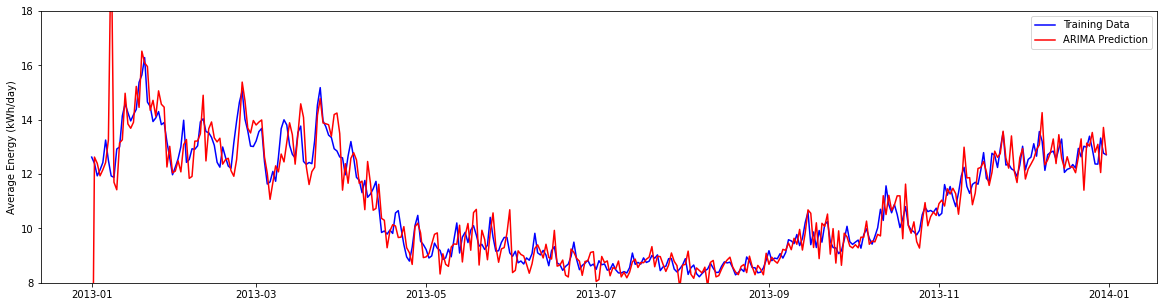

In [1118]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(y, color = 'b', label='Training Data')
ax1.plot(sarima_res.fittedvalues, color = 'r', label='ARIMA Prediction')
ax1.set_ylabel('Average Energy (kWh/day)')
ax1.legend()
ax1.set_ylim([8, 18])
plt.show()

SARIMA has a different pattern to ARIMA: we are no longer simply predicting some value based on the previous timestep's value. Instead we are making a more complex prediction. Although the MAE is a bit higher for the training data, we will see that the prediction for January 2014 is quite a bit better. This highlights the importance of validating models beyond just the training set.

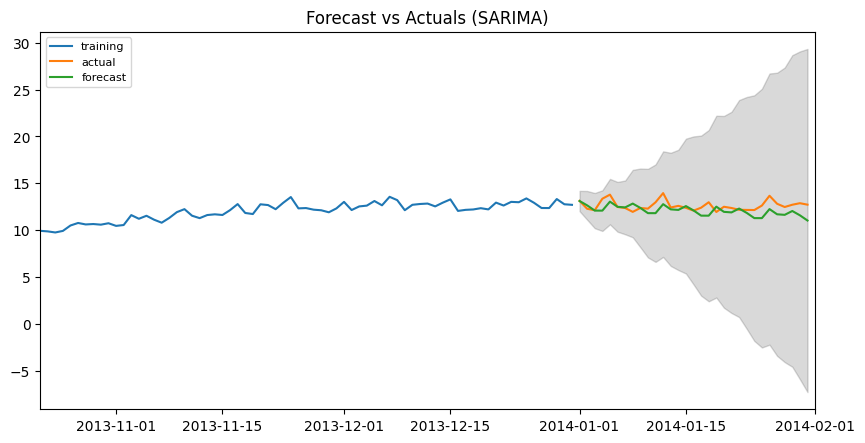

In [1142]:
# Forecast the future using SARIMA
sarima_forecast = sarima_res.get_forecast(len(test), alpha=0.05) # 95% conf

# Forecasts as pandas series
cis = sarima_forecast.conf_int()

# Plot forecast
plt.figure(figsize=(10,5), dpi=100)
plt.plot(y, label='training')
plt.plot(test, label='actual')
plt.plot(sarima_forecast.predicted_mean, label='forecast') 
plt.fill_between(cis.index, cis['lower energy(kWh/hh)'], cis['upper energy(kWh/hh)'], color='k', alpha=.15) 
plt.title('Forecast vs Actuals (SARIMA)')
plt.legend(loc='upper left', fontsize=8) 
ax = plt.gca()
ax.set_xlim([16000, 16102])
plt.show()

In [1179]:
# Calculating mean absolute error for the forecast
print(f"SARIMA TEST MAE: {sum(abs(sarima_forecast.predicted_mean - test))/len(test)}")

SARIMA TEST MAE: 0.6645931363191795


Here we can see that the SARIMA model looks quite a bit better than the ARIMA model when predicting January 2014. We now capture some of the fluctuations in energy usage, and we have tigher confidence intervals (at least initially!).

However, the MAE is somewhat larger: on average the model is off by 0.665 kWh for a given day.

## 6.5 Summary

_Conclusions:_

1. ARIMA model parameters can be set by careful examination of the time series being modelled: we need to check for stationarity to determining the differencing order (d), then we can either grid search for p and q parameters or we can check the autocorrelation and partial autocorrelation.
2. SARIMA models are more useful for forecasting if we have a time series that contains seasonal patterns. The seasonality parameter can be set by inspecting the original time series and trying to extract the period of the seasonal pattern.
3. Any ARIMA/SARIMA model will become less certain over time when predicting a time series that is not stationary. 

_Future questions:_
1. Can we try making predictions in a different scenario? For example, we may want to simply make a prediction for a few days in the future rather than an entire month. It would be interesting to make predictions for that time period on an interative period, allowing the (S)ARIMA model to update based on incoming data.
2. It's a bit disappointing that the SARIMA model was not clearly better than the ARIMA model. Perhaps a further exploration of parameter tuning is required.

# 7. Improving SARIMA predictions using weather data
As we observed earlier in this notebook, we have multiple weather features that have a strong relationship with electricity usage. This section looks at using these features to improve our SARIMA model. 

Technically we will switch to using a SARMIAX model, where the X comes from "eXogenous variables". All this means is that we have other time series variables (in this case our weather information) that can be instead used as weighted input to the model instead of being modeled directly by the ARIMA part of the model.

## 7.1 PCA on the weather to create a clearer feature subset

Before we use our weather variables, we're going to do some PCA. This is because we have a larger number of features that have some correlation with one another. This multicolinearity often makes models perform worse. PCA is an ideal tool that represents the original features in terms of orthogonal (i.e. uncorrelated) principal components. We can reduce the number of features we're using by ordering our principle components in terms of how much variance in the original data they explain, then selecting a subset of the top n principle components that cumulatively still explains lots of the variance. This means we remove redundant features, without losing much information.

For a more in depth discussion/demonstration of PCA, see [here](https://www.kaggle.com/code/ryanholbrook/principal-component-analysis).

First, we want to standardise our features to the same scale for PCA to work effectively.

In [347]:
features = ['temperatureMax', 'windBearing', 'dewPoint',
       'cloudCover', 'windSpeed', 'pressure', 'apparentTemperatureHigh',
       'visibility', 'humidity', 'apparentTemperatureLow',
       'apparentTemperatureMax', 'temperatureLow', 'temperatureMin',
       'temperatureHigh', 'apparentTemperatureMin', 'moonPhase']

X = day.copy()
y = X.pop('energy(kWh/hh)')
X = X.loc[:, features]
X = X.fillna(0)

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

Next, we perform PCA

In [348]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
0,-2.562825,0.424160,-1.028245,-0.361805,-0.476214,0.661142,0.314630,-0.865198,0.022148,0.303330,-0.169808,-0.050601,0.043377,0.151670,0.074277,0.045392
1,-1.245667,-1.054476,-0.766600,-0.411762,-0.168323,0.485533,0.130338,-0.834493,0.741930,-0.581319,-0.129812,0.089283,-0.034582,0.217150,0.044555,-0.068479
2,-0.057885,-1.442320,-1.209203,-0.108297,0.266696,0.626550,-0.037162,-0.730005,-0.159608,0.108855,-0.025605,0.140167,-0.131835,-0.058296,-0.027527,-0.001565
3,-0.652439,-1.260607,-1.490829,0.044266,0.305141,0.675264,-0.948308,-0.433501,-0.079100,-0.068035,0.014217,0.107361,-0.105350,-0.024109,0.086492,0.021205
4,-0.782471,-1.935836,-0.575841,-0.665289,-0.037866,0.697053,-0.347621,-0.154461,-0.233346,-0.051327,0.052868,0.057274,-0.095541,-0.032548,-0.027627,-0.002839


In [349]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    axs[1].axhline(y=0.9, color='r', linestyle='--')
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


Here I show how much variance is explained by each of the principal components. In the cumulative plot we can see that taking just the first 7 (out of 16 total) variables explains >90% of the variance in the original data (red dotted line). We can keep these 7 variables as our exogenous variables for the SARIMAX model.

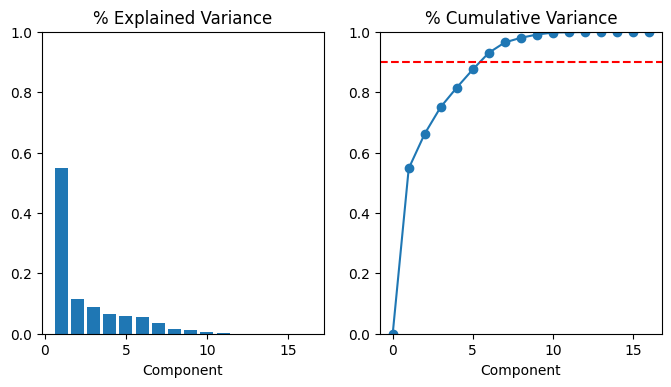

In [352]:
# > 90% cumulative explained variance with just 7 principal components (rather than the 16 weather variables)
plot_variance(pca)
plt.show()

## 7.2 SARIMAX using weather conditions as exogenous variables

Now we can go ahead and train the a SARMIAX model with the same parameters as before and with additional weather data.

In [1145]:
endog = y
exog = sm.add_constant(X_pca[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']].set_index(endog.index))


weather_sarimax = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(0, 1, 0),seasonal_order=(0, 1, 0, 7),
                                enforce_stationarity=False, enforce_invertibility=False)
weather_sarimax_res = weather_sarimax.fit()
print(weather_sarimax_res.summary())

/Users/hector/anaconda3/envs/kaggle/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/hector/anaconda3/envs/kaggle/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.14742D+00    |proj g|=  9.68662D-02
  ys=-5.007E+00  -gs= 9.011E-01 BFGS update SKIPPED

At iterate    5    f=  7.68390D-01    |proj g|=  2.60445D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      7     17      2     1     0   4.322D-05   7.684D-01
  F =  0.76839048607463822     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                            

In [1146]:
# Print SARIMAX mean absolute error
print('SARIMAX MAE: %.3f' % weather_sarimax_res.mae)

SARIMAX MAE: 0.473


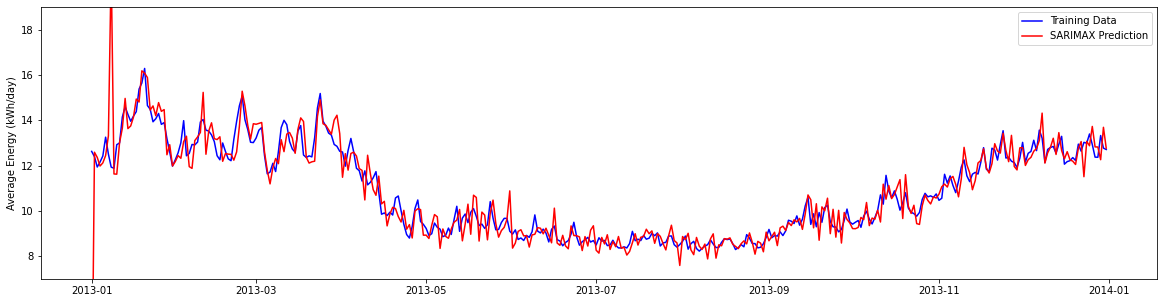

In [1148]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(y, color = 'b', label='Training Data')
ax1.plot(weather_sarimax_res.fittedvalues, color = 'r', label='SARIMAX Prediction')
ax1.set_ylabel('Average Energy (kWh/day)')
ax1.legend()
ax1.set_ylim([7, 19])
plt.show()

Before we can make a forecast for January 2014 we need to load in our weather variables and January 2014 and transform them with the PCA we previously fitted to the training data.

In [1156]:
# Loading in testing weather information
test_weather = pd.read_csv('archive/weather_daily_darksky.csv')
test_weather['time'] = pd.to_datetime(test_weather['time'])
test_weather = test_weather[(test_weather['time'].dt.year == 2014) & (test_weather['time'].dt.month == 1)]
test_weather['time'] =  pd.to_datetime(test_weather['time'],format='%Y%m%d').dt.date
test_weather['time'] = pd.to_datetime(test_weather['time'])

In [1169]:
# Standardising the data, filling nans etc. as we did for training data
test_exog = test_weather.loc[:, features]
test_exog = test_exog.fillna(0)

# Standardize
test_exog = (test_exog - X.mean(axis=0)) / X.std(axis=0)  # NOTE: we're using the mean and std of the training data

# Transforming the data with PCA from the training data
test_exog = pca.transform(test_exog)


# Limited to the first 7 principal components, and adding in index & names
test_exog = pd.DataFrame(data=test_exog[:, :7], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'],
                        index=test.index)

test_exog = sm.add_constant(test_exog)


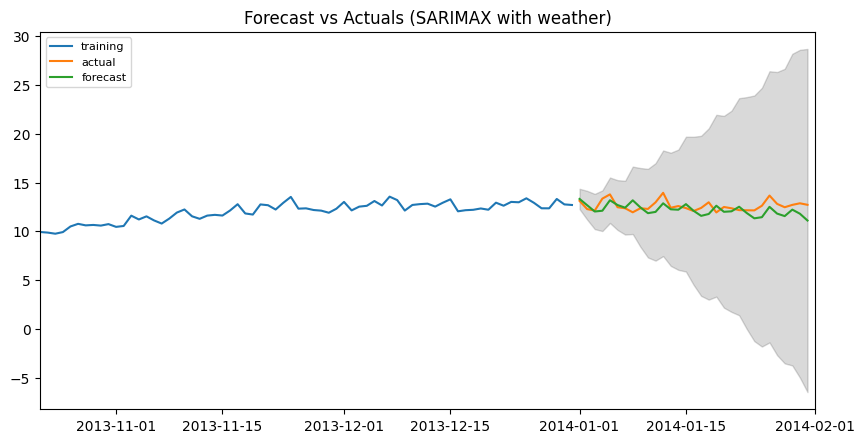

In [1170]:
# Forecast the future using SARIMAX with weather data
weather_sarimax_forecast = weather_sarimax_res.get_forecast(len(test), alpha=0.05, exog=test_exog) # 95% conf

# Forecasts as pandas series
cis = weather_sarimax_forecast.conf_int()

# Plot forecast
plt.figure(figsize=(10,5), dpi=100)
plt.plot(y, label='training')
plt.plot(test, label='actual')
plt.plot(weather_sarimax_forecast.predicted_mean, label='forecast') 
plt.fill_between(cis.index, cis['lower energy(kWh/hh)'], cis['upper energy(kWh/hh)'], color='k', alpha=.15) 
plt.title('Forecast vs Actuals (SARIMAX with weather)')
plt.legend(loc='upper left', fontsize=8) 
ax = plt.gca()
ax.set_xlim([16000, 16102])
plt.show()

In [1180]:
# Calculating mean absolute error for the forecast
print(f"SARIMAX TEST MAE: {sum(abs(weather_sarimax_forecast.predicted_mean - test))/len(test)}")

SARIMAX TEST MAE: 0.6436305885070485


It seems the SARIMAX model is slightly better than the SARIMA model: it is off by an average of 0.644 kWh for any given day (compared to 0.665 kWh for the SARIMA model). 

## 7.3 Summary

_Conclusions:_

1. SARIMAX models can improve prediction accuracy by incorporating variables other than the time series itself - known as exogenous variables. 
2. However, exogenous variables need to add extra information that is not captured by the time series already. In this case weather might not have improved predictions much because time of year captures a lot of the information about the weather (e.g. it's colder and darker in winter).

_Future questions:_
1. It would be really fun to try to use a different kind of model, such as [Prophet](https://facebook.github.io/prophet/) from facebook.
1. Can we try to gather more exogenous variables to make prediction quality even better? Some examples might be electricity pricing, bank holidays, school holidays etc.
2. Could weather information be more useful when predicting across an entire year when weather is more variable? January is uniformly pretty cold and dark in the UK. It might also be that weather information helps when trying to predict how electricity usage might relate to unexpected weather - e.g. unseasonably warm/cold days. As our climate continues to change, such events are increasingly likely and we need to take these into account.

# Appendix: Analysis of outliers - why are there some half hour periods with such high energy usage?

Although there's always more interesting analysis to do, you need to put a stop on a project eventually! Here's an appendix showing the beginnings of some analysis on a particularly interesting question that I might come back to: what drives high electricity usage?

In this dataset we have a lot of half hour periods where energy usage is significantly higher than the average. What drives this? Is it specific dates? Is it specific types of households. Exploring these questions can help energy providers target and reduce unnecessarily high energy consumption.

Let's flag the outliers using IQR (because data is not normally distributed). Then we can inspect their properties.

In [507]:
def find_outliers_IQR():

    q1=hlfhr['energy(kWh/hh)'].quantile(0.25)

    q3=hlfhr['energy(kWh/hh)'].quantile(0.75)

    IQR=q3-q1

    outliers = hlfhr[((hlfhr['energy(kWh/hh)']<(q1-1.5*IQR)) | (hlfhr['energy(kWh/hh)']>(q3+1.5*IQR)))]

    return outliers.sort_values(by='energy(kWh/hh)', ascending=False)

In [675]:
outliers = find_outliers_IQR()

In [605]:
outliers.head()

,LCLid,tstp,energy(kWh/hh),stdorToU,Acorn,Acorn_grouped
682953,MAC004179,2013-02-18 12:30:00,8.171,Std,ACORN-A,Affluent
239542,MAC003428,2013-09-14 21:30:00,7.411,Std,ACORN-A,Affluent
239541,MAC003428,2013-09-14 21:00:00,7.359,Std,ACORN-A,Affluent
695782,MAC004179,2013-11-12 19:00:00,7.330,Std,ACORN-A,Affluent
682956,MAC004179,2013-02-18 14:00:00,7.299,Std,ACORN-A,Affluent


Standard tariffs have more extreme outliers.

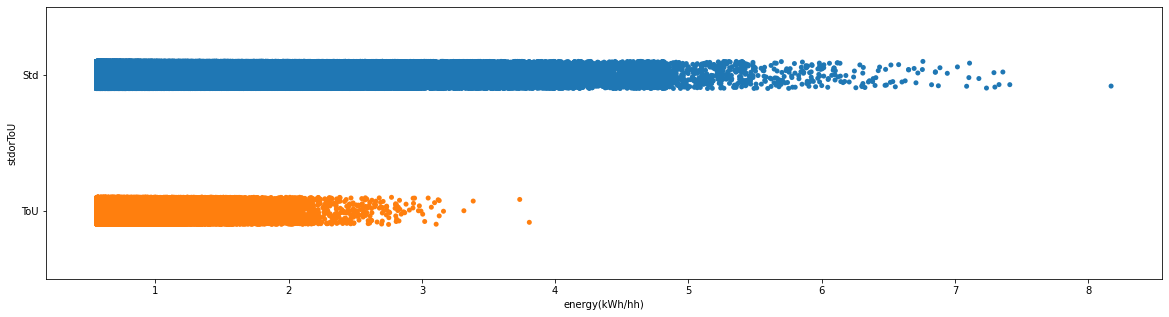

In [663]:
fig, ax1 = plt.subplots(figsize = (20,5))
sns.stripplot(data=outliers, y='stdorToU', x='energy(kWh/hh)')
plt.show()

<AxesSubplot:xlabel='stdorToU', ylabel='energy(kWh/hh)'>

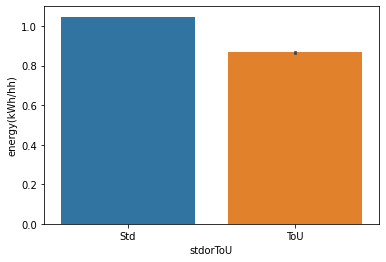

In [659]:
sns.barplot(data=outliers, x='stdorToU', y='energy(kWh/hh)')

Affluent households have more extreme outliers, but adversity and comfortable households hardly differ. 

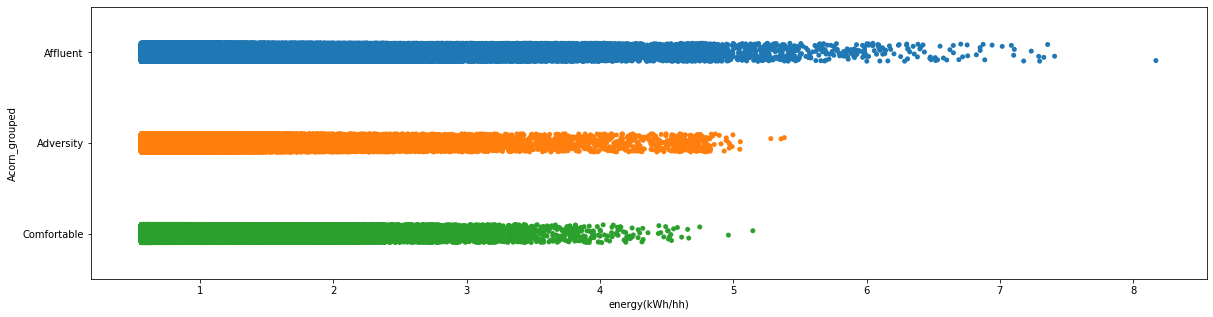

In [668]:
fig, ax1 = plt.subplots(figsize = (20,5))
sns.stripplot(data=outliers, y='Acorn_grouped', x='energy(kWh/hh)')
plt.show()

<AxesSubplot:xlabel='Acorn_grouped', ylabel='energy(kWh/hh)'>

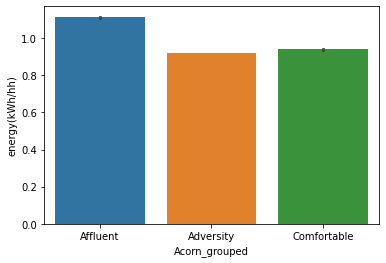

In [606]:
sns.barplot(data=outliers, x='Acorn_grouped', y='energy(kWh/hh)')

### Heatmap of number of outliers vs. house vs. day

In this heatmap below, I plot days vs households vs the number of outlier half hours per each day.

We can see vertical striping, indicating that some houses consistently have days containing many outlier half hours across the entire year. So some households just use a great deal more energy than normal.

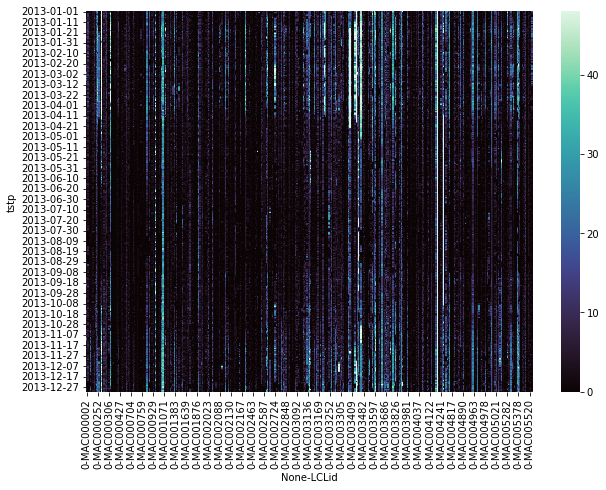

In [697]:
x = 'tstp'
y = 'LCLid'
#y = 'Acorn_grouped'

# This command counts outliers per day per y variable, and pads date index to daily (i.e. fills with zeros)
outlier_dist = outliers.groupby(
    [x, y]).size().reset_index().groupby(y).resample(
    'd', on='tstp', convention='end').sum().unstack(level=0).fillna(0)

# Setting index to be human readable
outlier_dist.set_index(outlier_dist.index.strftime("%d/%m"))
outlier_dist.index = outlier_dist.index.astype(str)

fig, ax1 = plt.subplots(figsize = (10,7))
sns.heatmap(outlier_dist, cmap='mako')


plt.show()

This is confirmed in the plot below, showing the number of households with a certain number of days that contain at least one outlier. It looks like some households just use a crazy amount of energy.

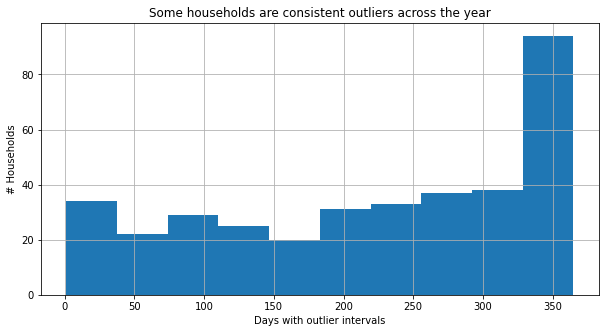

In [696]:
# Get number of outliers per day for each house
fig, ax1 = plt.subplots(figsize = (10,5))
test = outlier_dist.stack().reset_index()
test[test[0]>0].groupby('LCLid').size().hist()
ax1.set_xlabel('Days with outlier intervals')
ax1.set_ylabel('# Households')
ax1.set_title('Some households are consistent outliers across the year')
plt.show()

Here we can compare the household with the most outliers vs. the household with the fewest outliers

In [1185]:
outlier_dist.sum().sort_values(ascending=False)

   LCLid    
0  MAC004179    17520.0
   MAC004319    12353.0
   MAC001036    10881.0
   MAC000274     9771.0
   MAC003449     9723.0
                 ...   
   MAC002129        2.0
   MAC004772        2.0
   MAC003169        1.0
   MAC002664        1.0
   MAC001863        1.0
Length: 363, dtype: float64

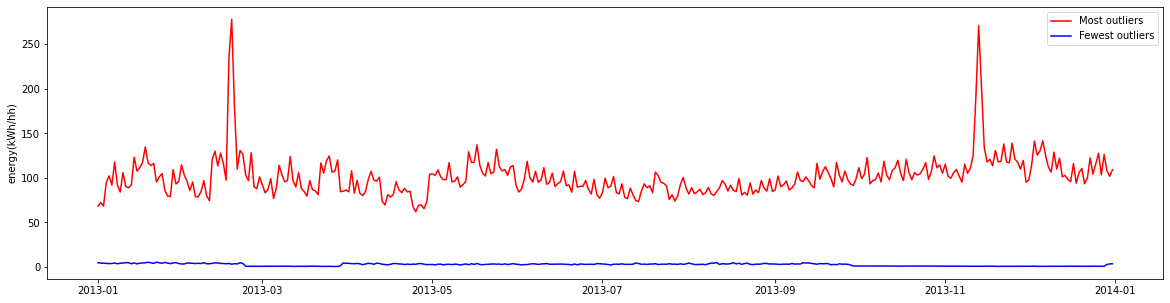

In [1192]:
temp = hlfhr.set_index('tstp').groupby('LCLid')['energy(kWh/hh)'].resample('d', convention='end').sum().reset_index()

fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(temp[temp['LCLid']=='MAC004179']['tstp'],
         temp[temp['LCLid']=='MAC004179']['energy(kWh/hh)'], color = 'r', label='Most outliers')

ax1.plot(temp[temp['LCLid']=='MAC002664']['tstp'],
         temp[temp['LCLid']=='MAC002664']['energy(kWh/hh)'], color = 'b', label='Fewest outliers')

ax1.set_ylabel('energy(kWh/hh)')
ax1.legend()
plt.show()

In [1189]:
temp.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000002,2013-01-01,10.800
1,MAC000002,2013-01-02,13.300
2,MAC000002,2013-01-03,10.074
3,MAC000002,2013-01-04,9.857
4,MAC000002,2013-01-05,11.171


This plot below shows the number of outliers per each day, with a clear seasonal trend.

In [584]:
outliers_by_day = outliers.groupby(
    'tstp').size().reset_index().resample(
    'd', on='tstp', convention='end').sum().reset_index().fillna(0).rename(columns={0: 'outlier_count'})

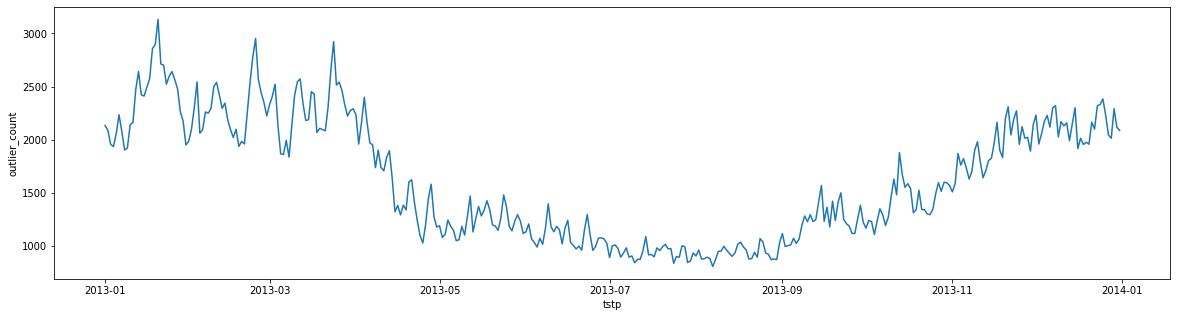

In [587]:
fig, ax1 = plt.subplots(figsize = (20,5))
sns.lineplot(data=outliers_by_day
              , x='tstp', y='outlier_count')
plt.show()

This plot below shows the number of outliers per eeach day of the week: we still have a weekly trend.

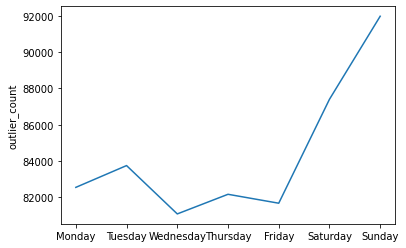

In [602]:
outlier_weekday = outliers_by_day.groupby(outliers_by_day['tstp'].dt.day_name()).sum()

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.lineplot(x=order, y=outlier_weekday.loc[order, 'outlier_count'])
plt.show()